In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sb
from scipy.stats import kurtosis, skew, spearmanr
from scipy.linalg import norm, lstsq
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
from scipy.stats import mode
from sklearn.neural_network import MLPRegressor

In [2]:
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = lstsq(C[:, idx], C[:, j])[0]
            beta_j = lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

/tmp/ipykernel_92226/2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/tmp/ipykernel_92226/2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/tmp/ipykernel_92226/2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/tmp/ipykernel_92226/2062588229.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i]

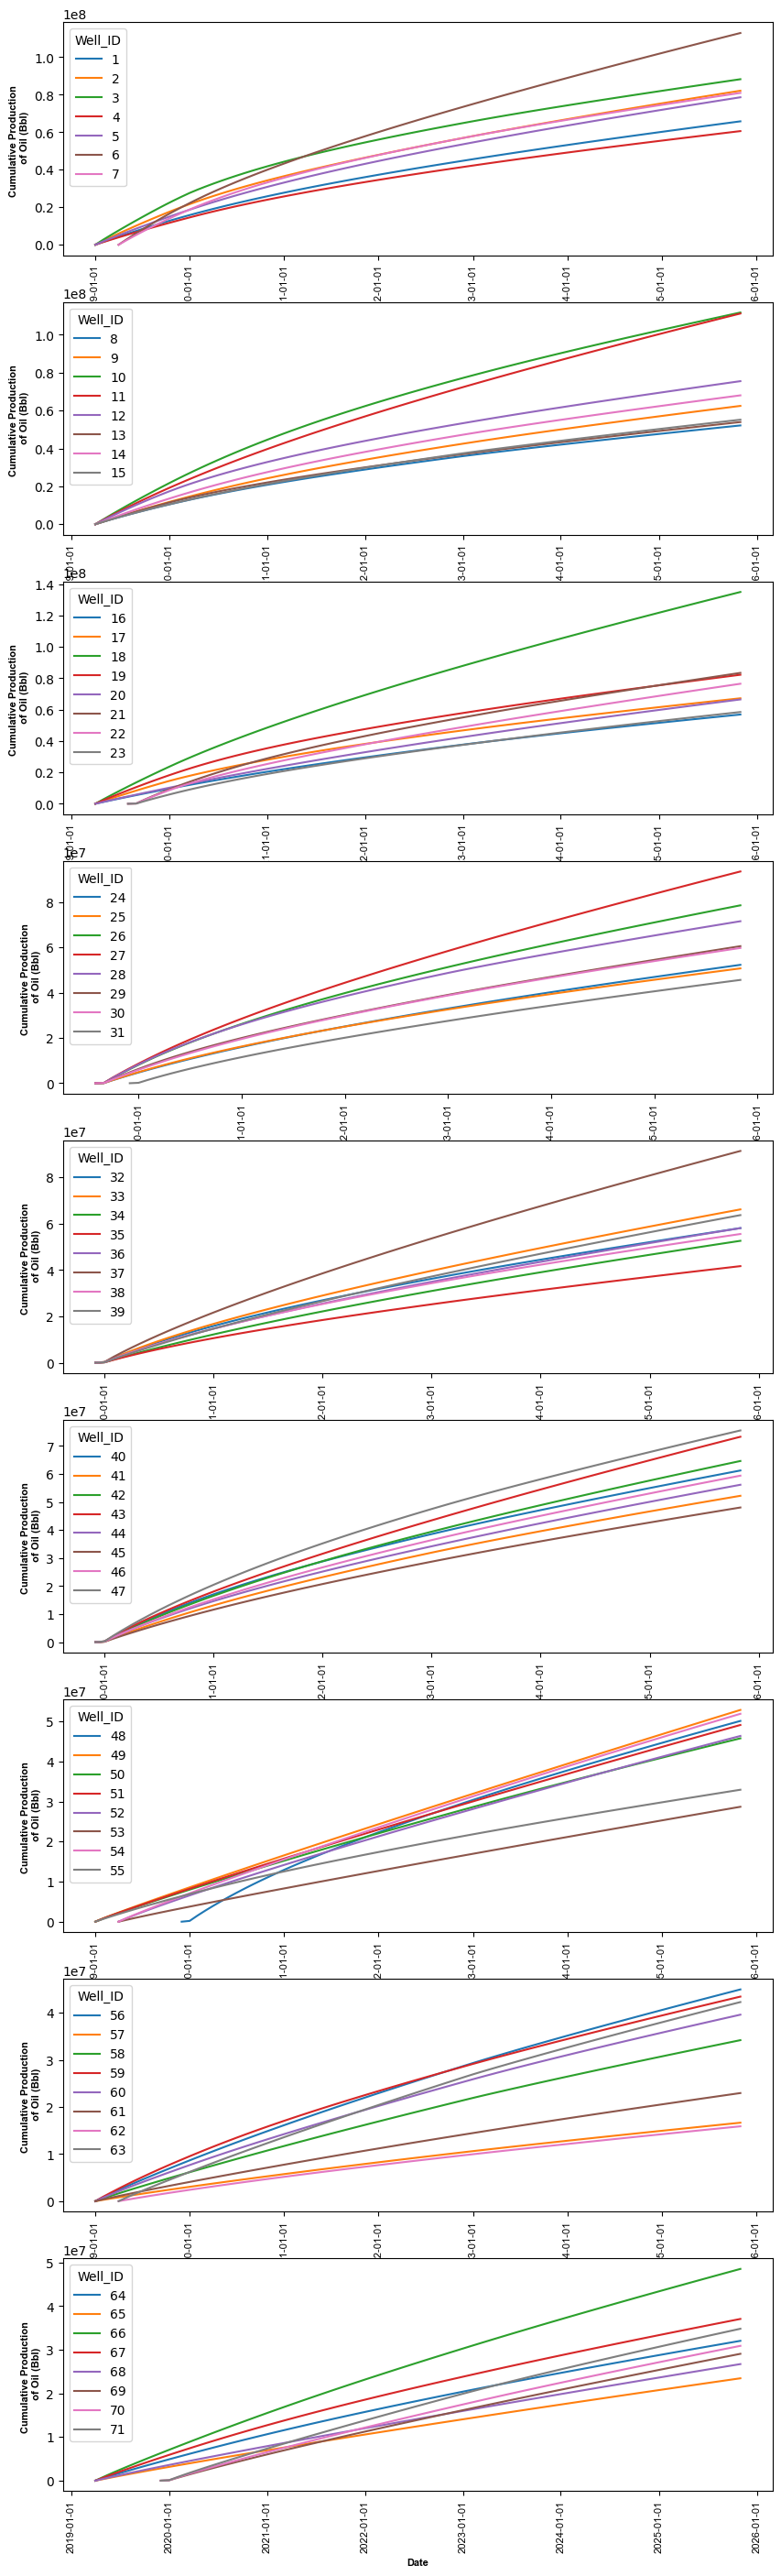

In [2]:


df = pd.read_csv( "production.csv",parse_dates=["Date"] )
fig,ax = plt.subplots( 9,1,figsize=(10,35) )




for i in range(9):
    wellidx     = i*8
    sb.lineplot( data=df[(df["Well_ID"]>=wellidx) & (df["Well_ID"]<=wellidx+7)], x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax[i] )
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [3]:
np.unique( df["Well_ID"] )

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71])

/tmp/ipykernel_85654/2628011662.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


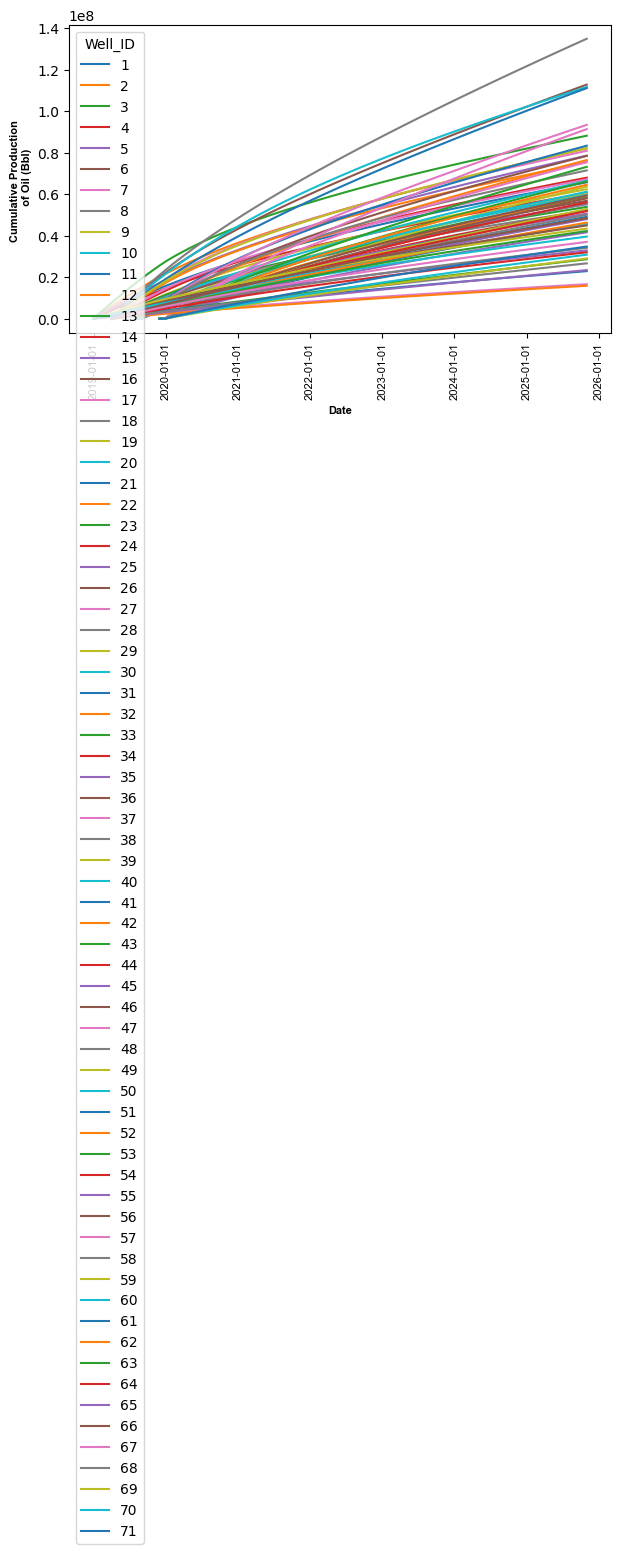

In [4]:
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=df, x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [3]:
dflogs = pd.read_csv( "logs.csv" )
 
df["gamma_var"] = 0
df["gamma_skew"] = 0
df["months"] = 0
df["mean_por"] = 0
df["mean_perm"] = 0
df["kurt_perm"] = 0
df["neighbor_density_25"] = 0
df["neighbor_density_70"] = 0
df["X"] = 0
df["Y"] = 0
df["cumulative_3y"] = 0
df["gamma_mean"] = 0
df["facies_p75"] = 0
df["z_mean"] = 0
df["acoustic_imp"] = 0
df["kophi_sqrt_of_means"] = 0
df["kophi_mean_of_sqrts"] = 0

def calculate_well_density( xvals,yvals,allx,ally,allIDs,quantile ):
    x   = xvals[0]
    y   = yvals[0]
    ids = np.unique( allIDs )
    dists = [  ]
    for id in ids:
        idxs=np.argwhere( allIDs==id )
        xs  = allx[idxs][0]
        ys  = ally[idxs][0]
        if x!=xs and y!=ys:
            dists.append( 1/norm( np.array([x-xs,y-ys]) ) )
    return np.min( dists )

for id in np.unique(dflogs["Well_ID"]):
    df.loc[df["Well_ID"]==id,"X"] = np.unique( dflogs[dflogs["Well_ID"]==id]["X"] )[0]
    df.loc[df["Well_ID"]==id,"Y"] = np.unique( dflogs[dflogs["Well_ID"]==id]["Y"] )[0]
    df.loc[df["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
    df.loc[df["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI"] )
    df.loc[df["Well_ID"]==id,"kophi_mean_of_sqrts"] = ( np.mean( np.sqrt(dflogs[dflogs["Well_ID"]==id]["perm"]/dflogs[dflogs["Well_ID"]==id]["phi"] ) ) )
    df.loc[df["Well_ID"]==id,"z_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["Z"] )
    df.loc[df["Well_ID"]==id,"gamma_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["GR"] )
    df.loc[df["Well_ID"]==id,"facies_p75"] = np.quantile( dflogs[dflogs["Well_ID"]==id]["facies"],0.75 )
    df.loc[df["Well_ID"]==id,"gamma_skew"] = skew( dflogs[dflogs["Well_ID"]==id]["GR"].values )
    df.loc[df["Well_ID"]==id,"mean_por"] = np.mean( dflogs[dflogs["Well_ID"]==id]["phi"] )
    df.loc[df["Well_ID"]==id,"mean_perm"] = np.mean( dflogs[dflogs["Well_ID"]==id]["perm"] )
    df.loc[df["Well_ID"]==id,"kurt_perm"] = kurtosis( dflogs[dflogs["Well_ID"]==id]["perm"].values )
    df.loc[df["Well_ID"]==id,"neighbor_density_25"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.25 )
    df.loc[df["Well_ID"]==id,"neighbor_density_70"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.7 )
    df.loc[df["Well_ID"] == id, "months"] = (
        df.loc[df["Well_ID"] == id, "Date"]
        - df.loc[df["Well_ID"] == id, "Date"].min(  )
    ).dt.days
    monthsWell          = df[df["Well_ID"]==id]["months"] - 36*30
    prodWell          = df[df["Well_ID"]==id]["Cumulative Oil Production, BBL"]
    df.loc[df["Well_ID"]==id,"cumulative_3y"] = np.min( prodWell[monthsWell>0] )
    
df["months"]=df["months"]/30

/tmp/ipykernel_92226/2166421704.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.616559342992652' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
/tmp/ipykernel_92226/2166421704.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5096851.315789473' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI"] )
/tmp/ipykernel_92226/2166421704.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '54.70295417296884' has dtype incompatible with int64, please explicitly cast to a compatible dtype firs

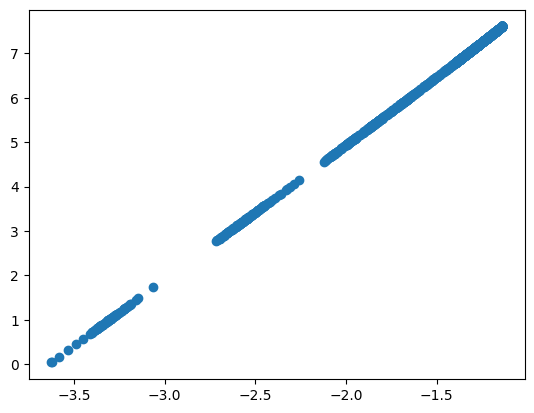

In [6]:
plt.scatter( np.log( dflogs["phi"] ),np.log(dflogs["perm"]) )

In [7]:
df

Well_ID       Date  Cumulative Gas Production, ft3  \
0           1 2019-01-01                    0.000000e+00   
1           1 2019-02-01                    1.981249e+09   
2           1 2019-03-01                    3.661006e+09   
3           1 2019-04-01                    5.474707e+09   
4           1 2019-05-01                    7.194637e+09   
...       ...        ...                             ...   
5512       71 2025-07-01                    4.209285e+10   
5513       71 2025-08-01                    4.262622e+10   
5514       71 2025-09-01                    4.315820e+10   
5515       71 2025-10-01                    4.367173e+10   
5516       71 2025-11-01                    4.420112e+10   

      Cumulative Oil Production, BBL  Cumulative Water Production, BBL  \
0                               0.00                      0.000000e+00   
1                         1560038.50                      4.634771e+04   
2                         2882681.25                      8.738335e+04   
3                         4310793.00                      1.334990e+05   
4                         5665069.00                      1.791346e+05   
...                              ...                               ...   
5512                     33143974.00                      2.761039e+06   
5513                     33563956.00                      2.809077e+06   
5514                     33982832.00                      2.857320e+06   
5515                     34387188.00                      2.904204e+06   
5516                     34804032.00                      2.952848e+06   

      gamma_var  gamma_skew     months  mean_por   mean_perm  ...  \
0     12.616559         NaN   0.000000  0.225434  884.329315  ...   
1     12.616559         NaN   1.033333  0.225434  884.329315  ...   
2     12.616559         NaN   1.966667  0.225434  884.329315  ...   
3     12.616559         NaN   3.000000  0.225434  884.329315  ...   
4     12.616559         NaN   4.000000  0.225434  884.329315  ...   
...         ...         ...        ...       ...         ...  ...   
5512  27.173784    0.225046  67.966667  0.176152  429.657251  ...   
5513  27.173784    0.225046  69.000000  0.176152  429.657251  ...   
5514  27.173784    0.225046  70.033333  0.176152  429.657251  ...   
5515  27.173784    0.225046  71.033333  0.176152  429.657251  ...   
5516  27.173784    0.225046  72.066667  0.176152  429.657251  ...   

      neighbor_density_70    X    Y  cumulative_3y  gamma_mean  facies_p75  \
0                0.005692   33  127     2882681.25    34.50313         NaN   
1                0.005692   33  127     2882681.25    34.50313         NaN   
2                0.005692   33  127     2882681.25    34.50313         NaN   
3                0.005692   33  127     2882681.25    34.50313         NaN   
4                0.005692   33  127     2882681.25    34.50313         NaN   
...                   ...  ...  ...            ...         ...         ...   
5512             0.005708  151  166      812823.00    58.07322         5.0   
5513             0.005708  151  166      812823.00    58.07322         5.0   
5514             0.005708  151  166      812823.00    58.07322         5.0   
5515             0.005708  151  166      812823.00    58.07322         5.0   
5516             0.005708  151  166      812823.00    58.07322         5.0   

      z_mean  acoustic_imp  kophi_sqrt_of_means  kophi_mean_of_sqrts  
0         29  5.096851e+06                    0            54.702954  
1         29  5.096851e+06                    0            54.702954  
2         29  5.096851e+06                    0            54.702954  
3         29  5.096851e+06                    0            54.702954  
4         29  5.096851e+06                    0            54.702954  
...      ...           ...                  ...                  ...  
5512      29  6.083808e+06                    0            42.329698  
5513      29  6.083808e+06                    0            42.

/tmp/ipykernel_85654/1949035277.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


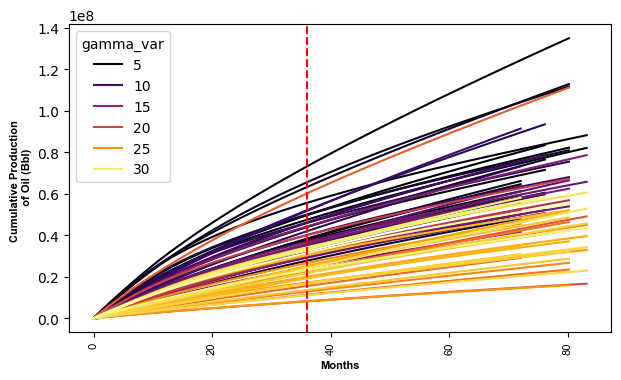

In [8]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_var",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_85654/681984011.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


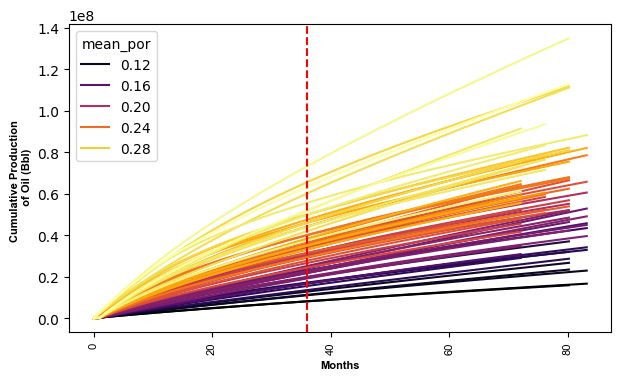

In [9]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_por",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_85654/2076334418.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


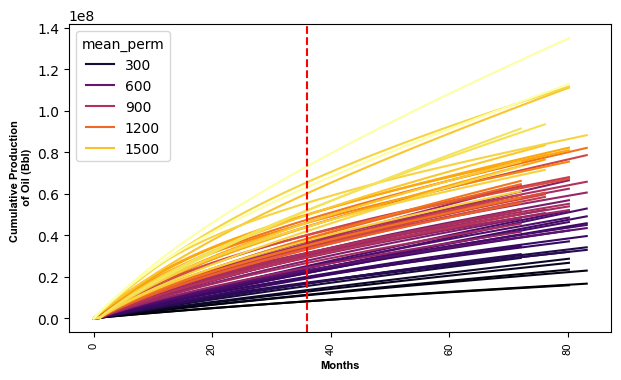

In [10]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_perm",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_85654/1183271054.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


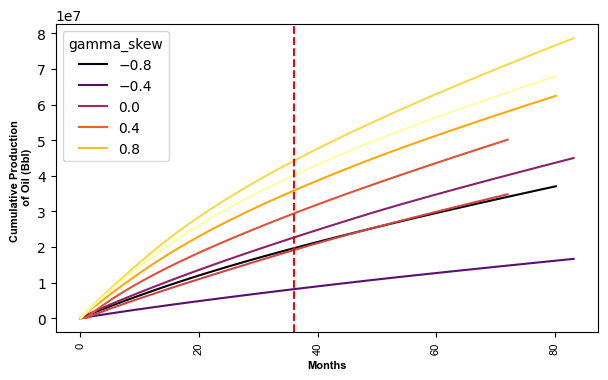

In [11]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_skew",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/tmp/ipykernel_85654/1660267431.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


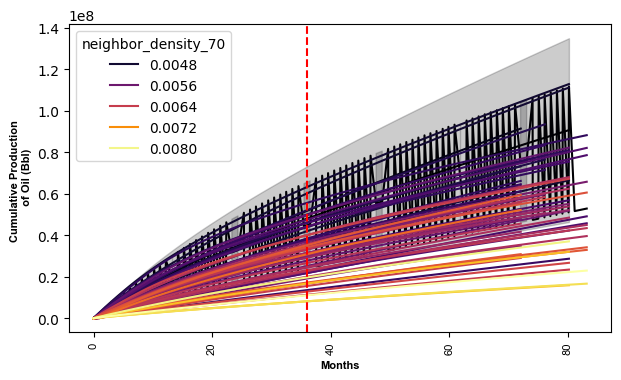

In [12]:
fig,ax = plt.subplots( figsize=(7,4 ) )

sb.lineplot( data=df, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="neighbor_density_70",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

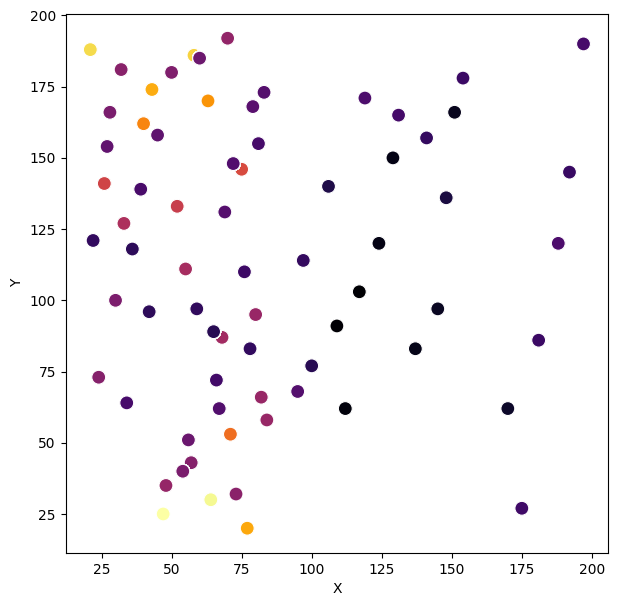

In [13]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="cumulative_3y",palette="inferno",ax=ax,s=100 );
ax.legend().remove()


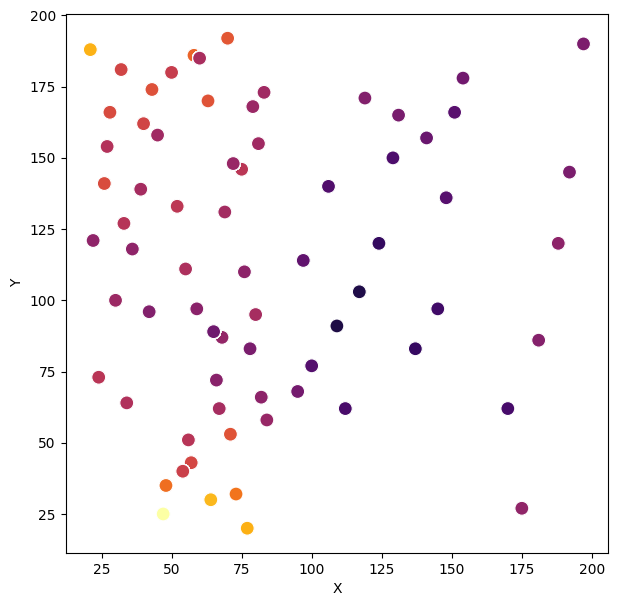

In [14]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

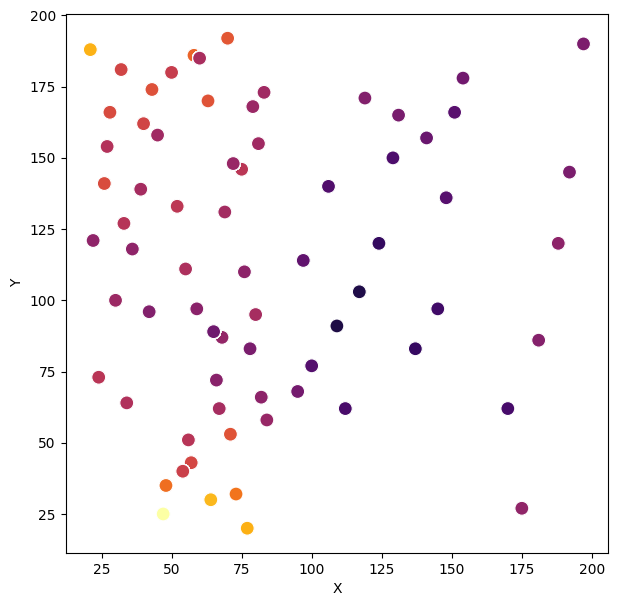

In [15]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=df,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

In [4]:
df_out = df.groupby("Well_ID", as_index=False).first(  )

In [5]:
df_out = df_out[["gamma_var","gamma_mean","mean_por","mean_perm","neighbor_density_25","neighbor_density_70","facies_p75","Y","X","acoustic_imp","kophi_mean_of_sqrts","Well_ID","cumulative_3y"]]

In [6]:
corrs  = [  ]
rcorrs = [  ]
pcorrs =  partial_corr(df_out.values)[:,-1][:-1]

features = [ "gamma_var","mean_por","mean_perm","neighbor_density_25","neighbor_density_70" ]
for f in features:
    corrs.append( pearsonr( df_out[f],df_out["cumulative_3y"] )[0] )
    rcorrs.append( spearmanr( df_out[f],df_out["cumulative_3y"] )[0] )
    
fig,ax = plt.subplots(1,3,figsize=(13,4))
ax[0].bar( features,corrs,color="teal" );
ax[0].set_ylim(-1,1)
ax[0].set_xticklabels(ax[0].get_xticklabels(  ),rotation=90);

ax[1].bar( features,rcorrs,color="teal" );
ax[1].set_ylim(-1,1)
ax[1].set_xticklabels(ax[1].get_xticklabels(  ),rotation=90);

ax[2].bar( features,pcorrs,color="teal" );
ax[2].set_ylim(-1,1)
ax[2].set_xticklabels(ax[2].get_xticklabels(  ),rotation=90);

NameError: name 'partial_corr' is not defined

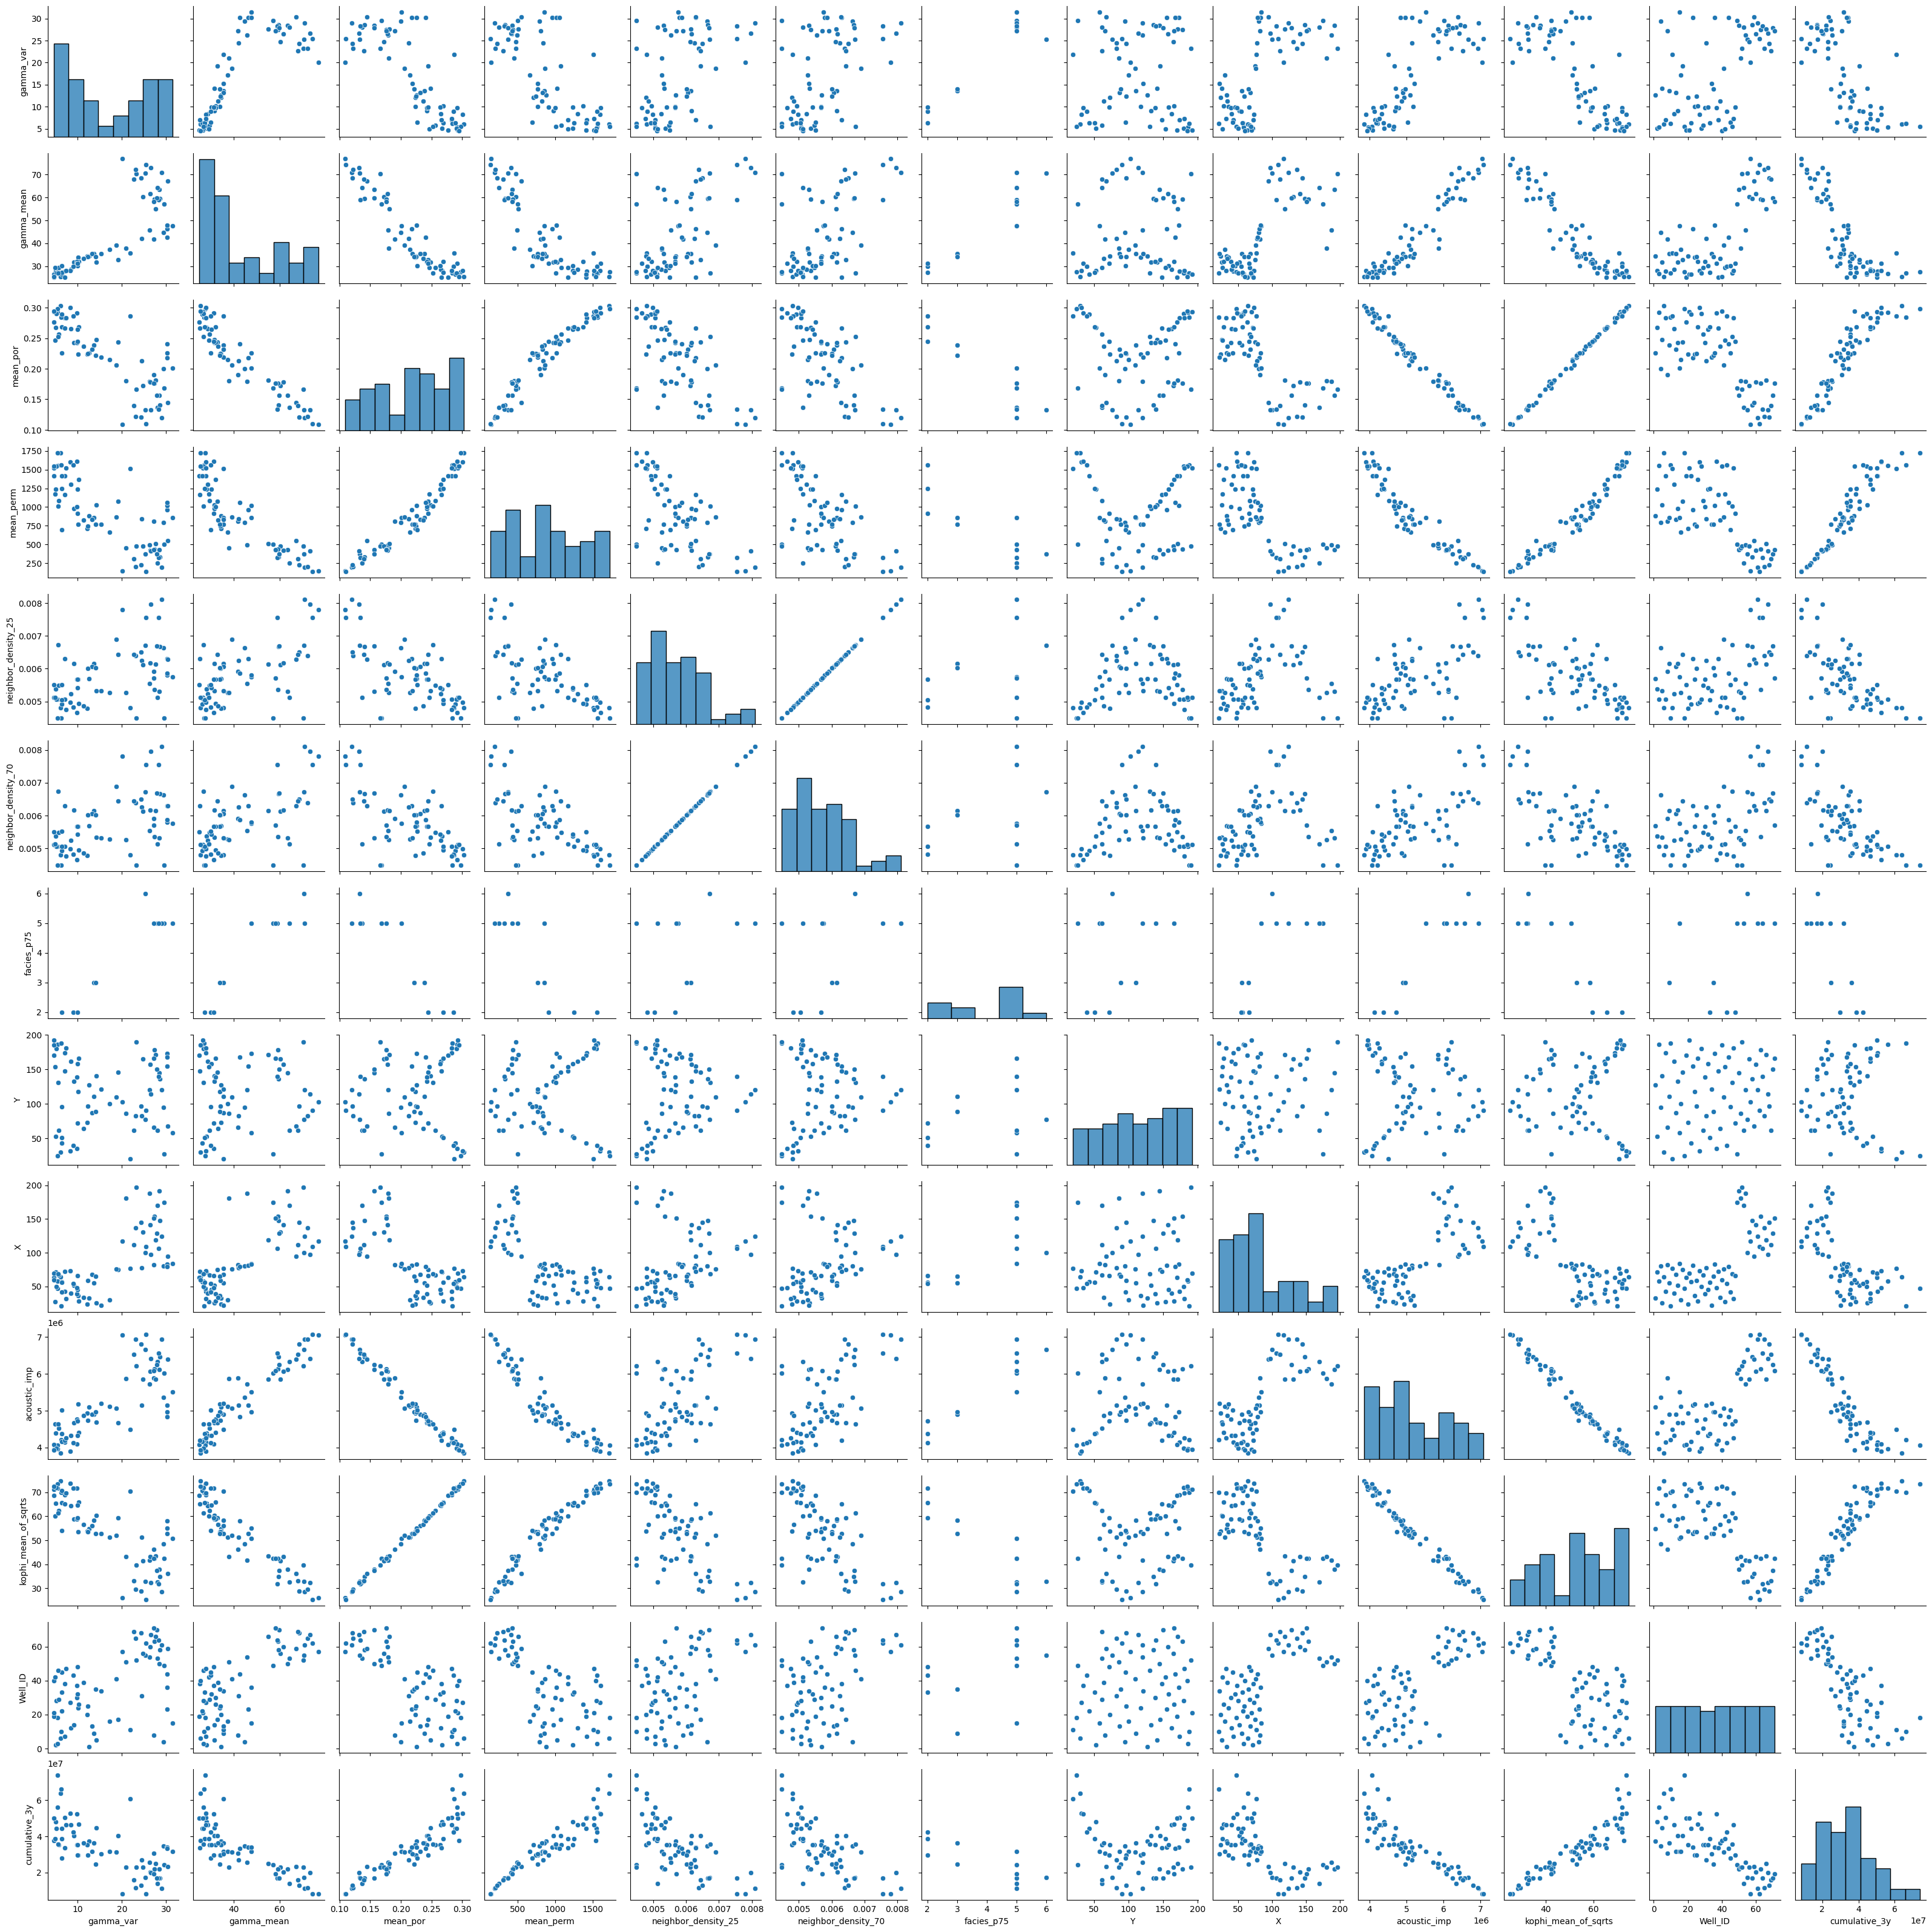

In [7]:
sb.pairplot(df_out)

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

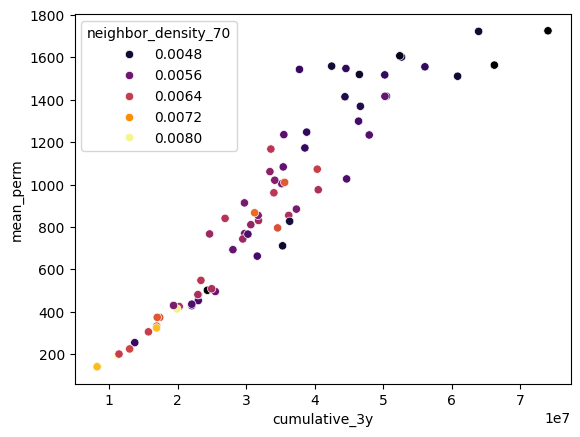

In [8]:
df_out["is_crowded"] = np.where(df_out["neighbor_density_70"]>0.006,1,0)
# sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="is_crowded",palette="inferno" )
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="neighbor_density_70",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

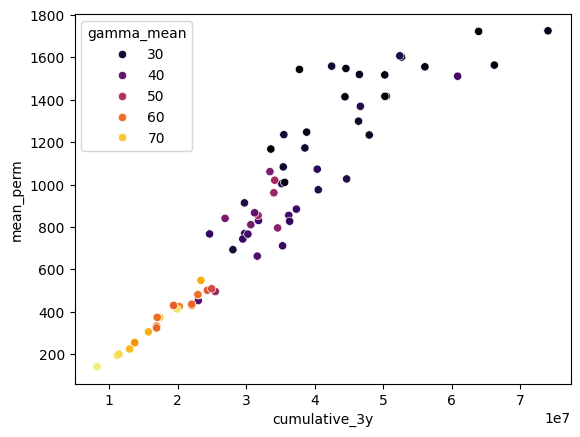

In [9]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="gamma_mean",palette="inferno" )

In [10]:
df_facies = pd.read_csv("facies.csv")
df_out["facies_percentage"] = df_facies["Percentage_Facies_3_or_Less"]

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

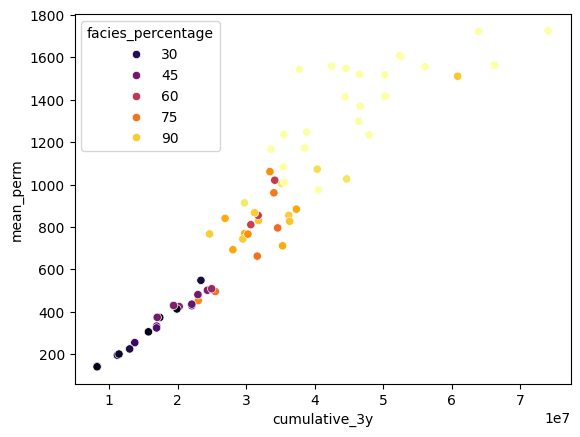

In [11]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="facies_percentage",palette="inferno" )

In [12]:
df_out["y_north"] = np.where( (df_out["X"]<100) & (df_out["Y"]<100),"North","South" )
df_out["x_east"] = np.where( df_out["X"]>=80,"East","West" )
df_out["region"] = np.where( (df_out["X"]<=90) & ((df_out["Y"]<70) | (df_out["Y"]>125)),"in_region","out_region" )
df_out["region_north"] = np.where( (df_out["region"]=="in_region") & (df_out["Y"]<100),"in_region_north","in_region_south" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

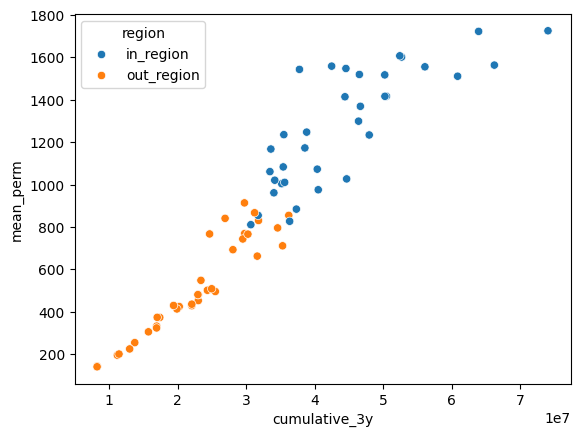

In [13]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="region",palette="tab10" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

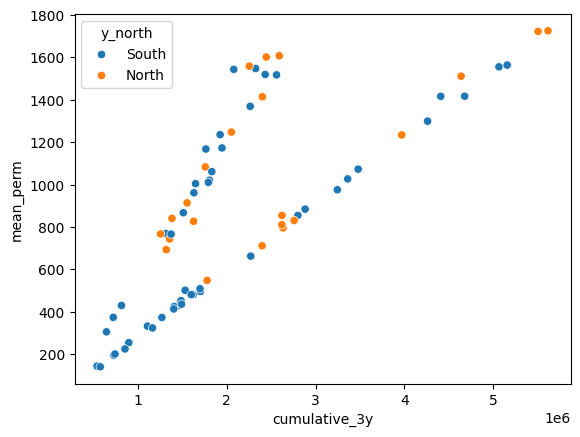

In [23]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="y_north",palette="tab10" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

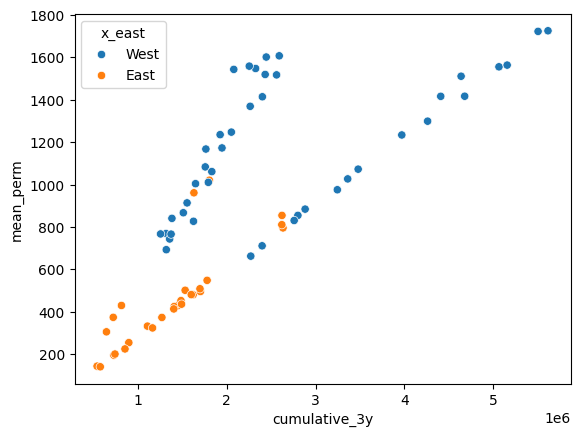

In [24]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="x_east",palette="tab10" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

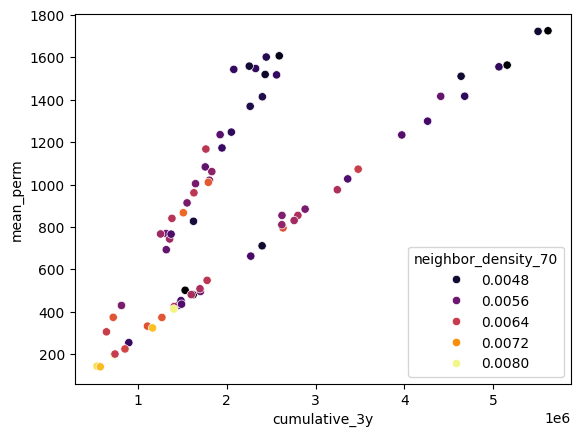

In [25]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="neighbor_density_70",palette="inferno" )

In [26]:
df_mechanical = pd.read_csv( "mechanical.csv" )
df_out["brittleness"] = df_mechanical["Mean_Brittleness_Index"]
df_out["young"] = df_mechanical["Mean_Youngs_Modulus_Velocities"]
df_out["poisson"] = df_mechanical["Mean_Poisson_Ratio_Ksat_Gsat"]

In [27]:
df_out["is_well_id"] = np.where(df_out["Well_ID"]>50,"fifties","forties")

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

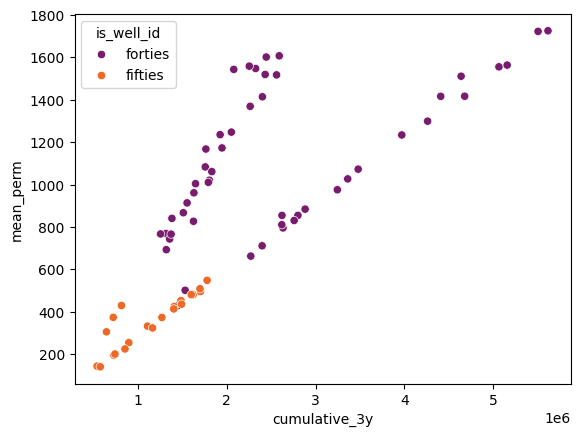

In [28]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="is_well_id",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

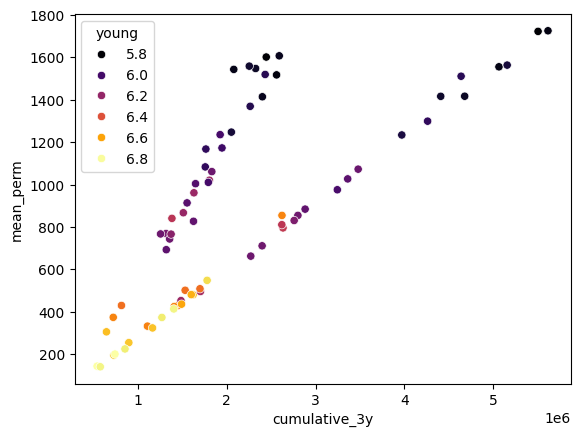

In [29]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="young",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

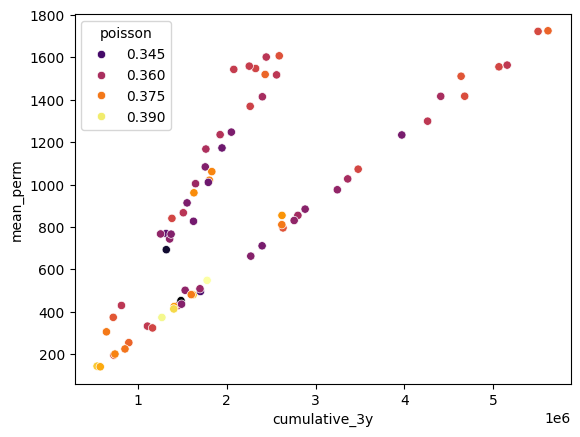

In [30]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="poisson",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

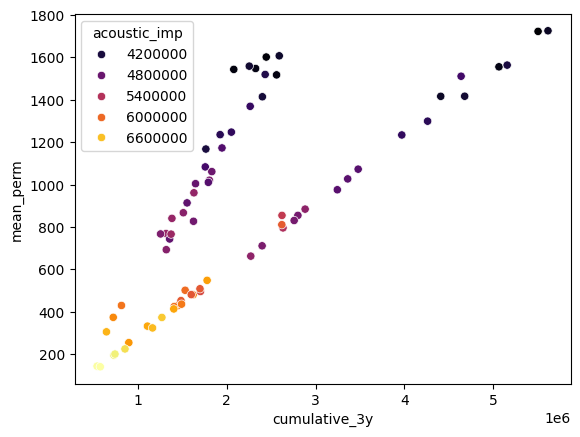

In [31]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="acoustic_imp",palette="inferno" )


<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

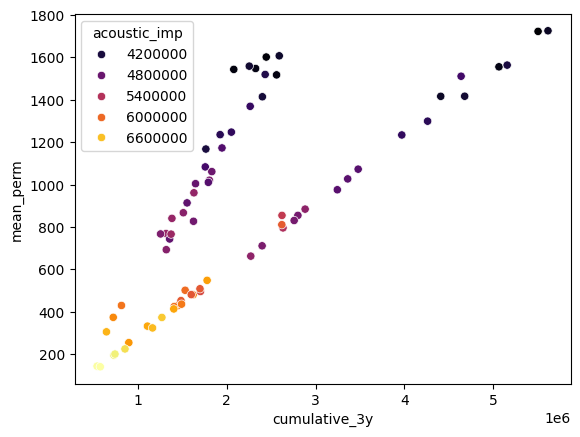

In [32]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="acoustic_imp",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

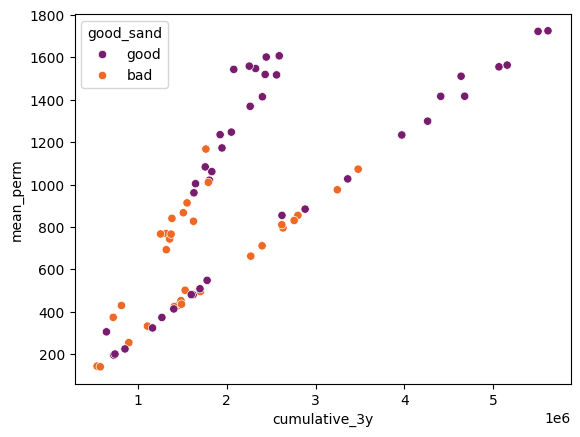

In [33]:
df_perm_facies = pd.read_csv("perm_facies.csv")
df_out["mean_perm_f2"] = df_perm_facies["facies_2"]
df_out["good_sand"] = np.where( df_perm_facies["facies_2"]>1200,"good","bad" )
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="good_sand",palette="inferno" )

<Axes: xlabel='mean_perm', ylabel='cumulative_3y'>

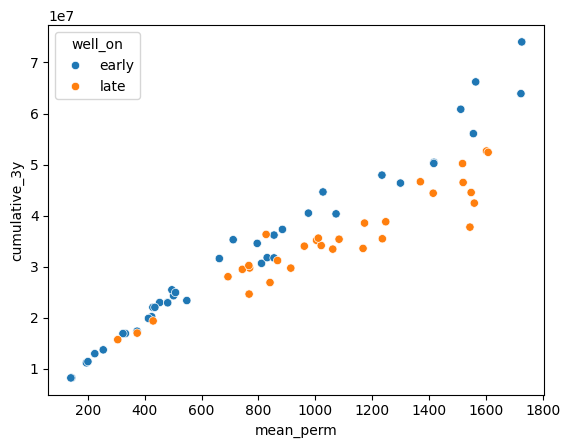

In [14]:
df_times = pd.read_csv( "times.csv",parse_dates=["earliest"] )
df_times["is_before_cutoff_2"] = np.where( df_times["earliest"]<pd.to_datetime( "2019-08-01",format="%Y-%m-%d" ),1,0 )
df_out["well_on"] = np.where(df_times["is_before_cutoff_2"],"early","late")
sb.scatterplot( data=df_out,y="cumulative_3y",x="mean_perm",hue="well_on",palette="tab10" )

## Training Model with Only Late Wells

/tmp/ipykernel_92226/2484556113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
/tmp/ipykernel_92226/2484556113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["logperm"] = np.log( df_train["mean_perm"] )


<Axes: xlabel='logperm', ylabel='cumulative_3y'>

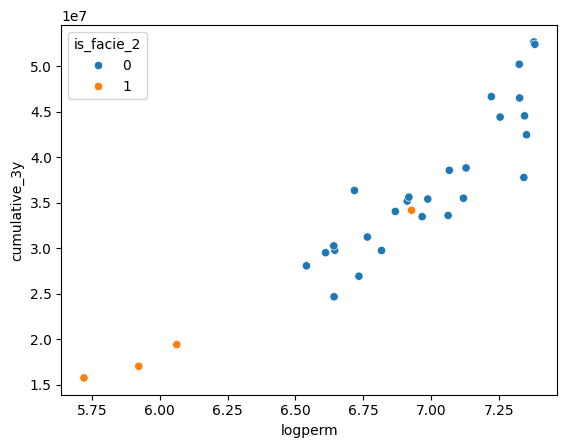

In [15]:
df_train = df_out[df_out["well_on"]=="late"]
df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
df_train["logperm"] = np.log( df_train["mean_perm"] )
sb.scatterplot( data=df_train,x="logperm",y="cumulative_3y",hue="is_facie_2",palette="tab10" )

/home/acmontesh/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.052e+14, tolerance: 1.791e+11
  model = cd_fast.enet_coordinate_descent(
/home/acmontesh/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.361e+14, tolerance: 2.502e+11
  model = cd_fast.enet_coordinate_descent(
/home/acmontesh/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

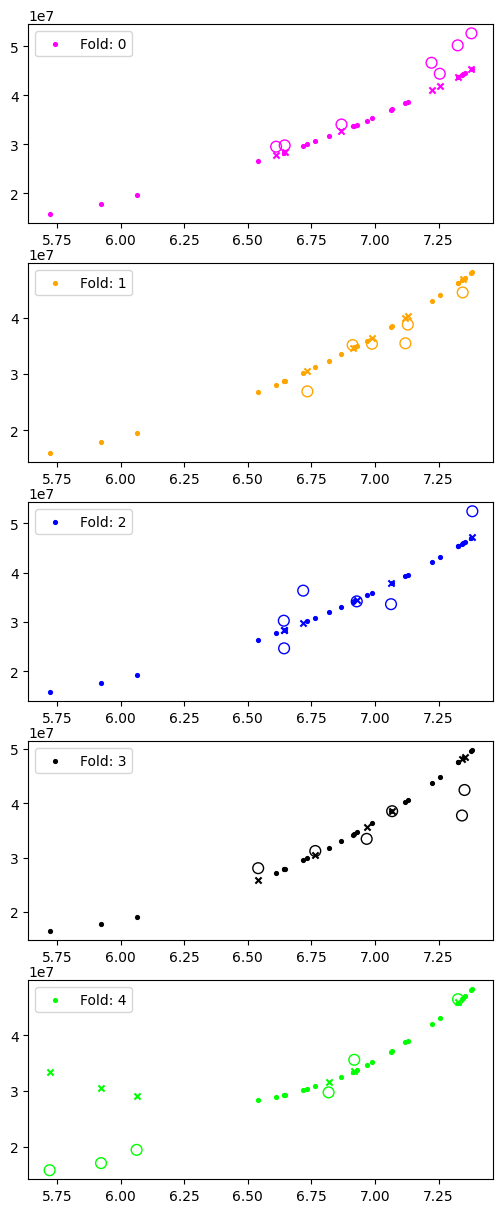

In [16]:
fig,ax = plt.subplots( 5,1,figsize=(6,15) )

X = df_train["logperm"].values
# X = df_train[["X","Y"]].values
y = df_train["cumulative_3y"].values
kf = KFold(n_splits=5 ,shuffle=False)
r2scores = [  ]
cols = ["magenta","orange","blue","black","lime"]

for i, (train_index, test_index) in enumerate(kf.split(X)):

    poly=PolynomialFeatures(degree=7,include_bias=True)    

    pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', Lasso(  ))] )
    X_train, X_test, y_train, y_test = X[train_index].reshape(-1,1),X[test_index].reshape(-1,1),y[train_index],y[test_index]
    poly_features=poly.fit_transform(X_train.reshape(-1,1))
    poly_test=poly.transform( X_test.reshape(-1,1) )
    pipe.fit(poly_features, y_train)

    ypred = pipe.predict( poly_test )
    ytrainpreds = pipe.predict( poly_features )  

    # ypred =   pipe.predict( X_test )
    # ytrainpreds = pipe.predict( X_train )

    ax[i].scatter( X_train,ytrainpreds,color=cols[i],lw=1.5,label=f"Fold: {i}",s=5 )
    ax[i].scatter( X_test,ypred,marker="x",s=20,color=cols[i] )
    ax[i].scatter( X_test,y_test,marker="o",s=60,edgecolors=cols[i],facecolors='None' )

    r2scores.append( r2_score( y[test_index],ypred ) )
    ax[i].legend(  )

# pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', BaggingRegressor( estimator=Lasso(  ),oob_score=True,n_estimators=100,bootstrap=True ))] )
# pipe.fit( X.reshape(-1,1),y )
# bag = pipe.named_steps["model"]
# oob_pred = bag.oob_prediction_


In [17]:
r2scores

[0.7525490116547237,
 0.7377509553639483,
 0.7591065960775119,
 -0.11103707959535503,
 0.20117953666115096]

In [18]:
r2scores

[0.7525490116547237,
 0.7377509553639483,
 0.7591065960775119,
 -0.11103707959535503,
 0.20117953666115096]

<h1> Model 1: One Feature </h1>

## Uncertainty Model

In [19]:
realizations_per_sample = {  }
for i in range(df_train.shape[0]):
    withold_point = df_train.iloc[i,:]
    x_wh = withold_point["logperm"].reshape(-1,1)
    y_hw = withold_point["cumulative_3y"]
    new_df      = pd.concat( [df_train.iloc[0:i,:],df_train.iloc[i+1:,:]] )
    X           = new_df["logperm"].values
    y           = new_df["cumulative_3y"].values
    realizations_per_sample[ i ] = { "actual":y_hw,"reals":[  ] }
    for j in range(100):
        degree_rand = np.random.randint( 3 )   
        model_type_rand =  0#np.random.randint( 0,4 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ),AdaBoostRegressor(  ),LinearRegression(  )]
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.80 )
        model = model_types[model_type_rand]
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        if model_type_rand<=1:
            poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features=poly.fit_transform(X_train.reshape(-1,1))
            poly_test=poly.transform( x_wh.reshape(-1,1) )
            pipe.fit(poly_features, y_train)
            # ypred = pipe.predict( poly_test )
            # ytrainpreds = pipe.predict( poly_features )
            ywhp = pipe.predict( poly_test )[0]
        else:
            pipe.fit(X_train.reshape(-1,1), y_train)
            ywhp = pipe.predict( x_wh )[0]
        
        
        realizations_per_sample[ i ]["reals"].append( ywhp )


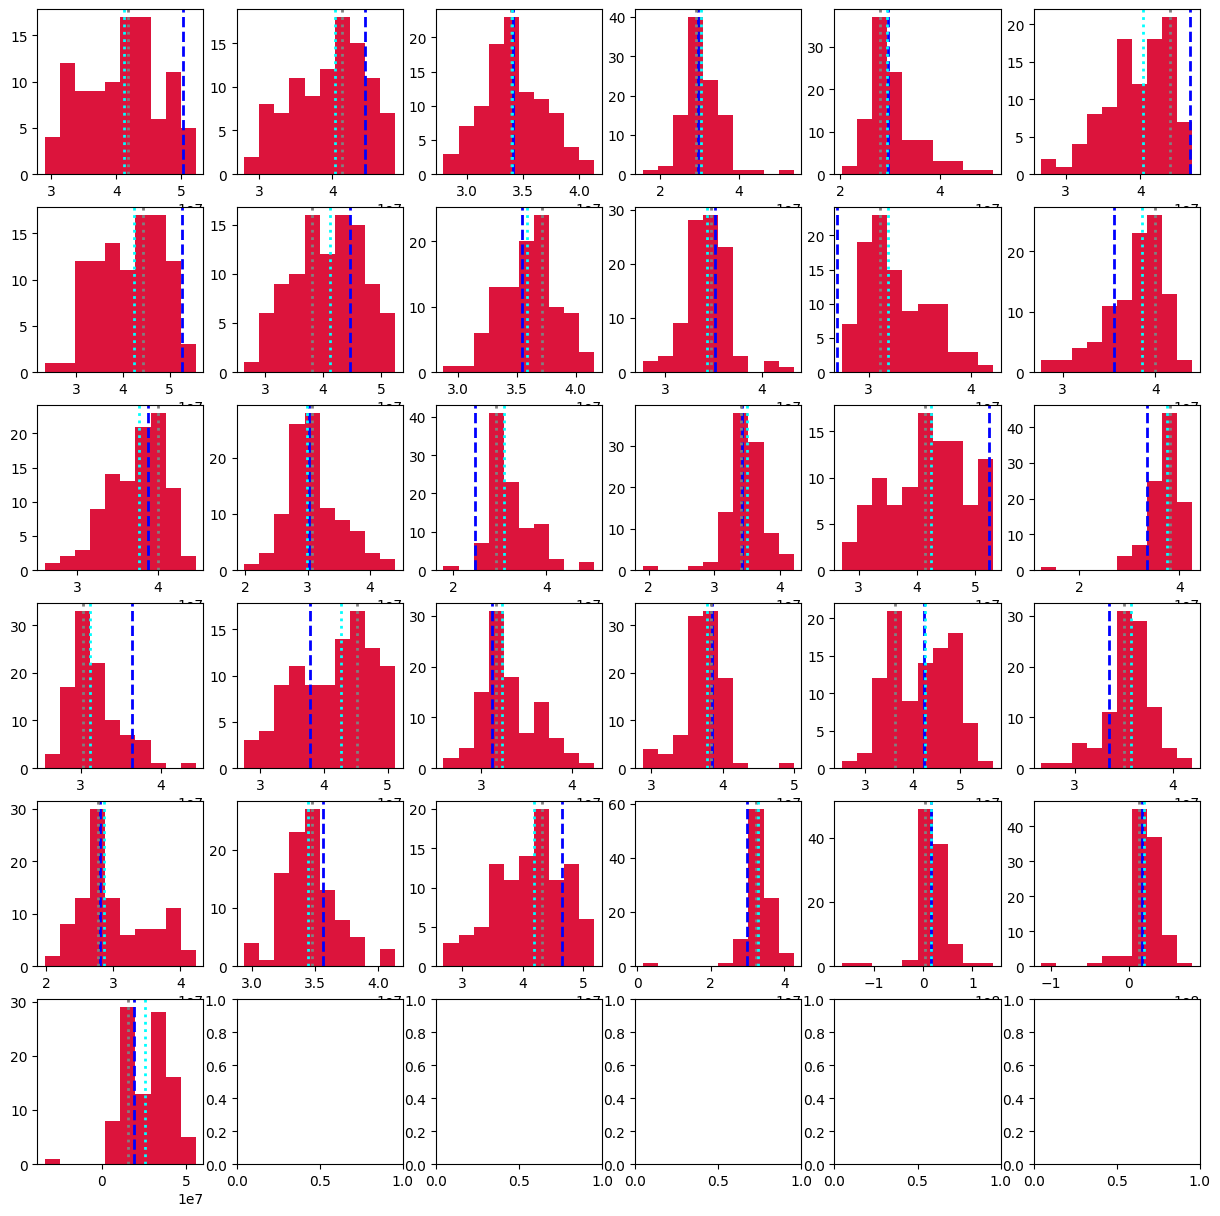

In [20]:
fig,axs = plt.subplots( 6,6,figsize=(15,15),facecolor="white" )
for k in range(df_train.shape[0]):
    row = k//6
    colm = k%6
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ k ]["reals"],color="crimson" )
    imax = np.argmax(counts)
    midpoint = 0.5 * (bin_edges[imax] + bin_edges[imax + 1])
    axs[row,colm].axvline( realizations_per_sample[ k ]["actual"],ls="--",lw=2.0,color="blue" )
    axs[row,colm].axvline( midpoint,ls="dotted",lw=2.0,color="gray" )
    axs[row,colm].axvline( np.median( realizations_per_sample[ k ]["reals"] ),ls="dotted",lw=2.0,color="cyan" )

In [21]:
counts = [ ]
for percent_value in np.arange(0,1.1,0.1):
    count = 0
    outside_range=1-percent_value
    for k in range(df_train.shape[0]):
        if (realizations_per_sample[ k ]["actual"]>=np.quantile( realizations_per_sample[ k ]["reals"],outside_range/2 )) and (realizations_per_sample[ k ]["actual"]<=np.quantile( realizations_per_sample[ k ]["reals"],1-outside_range/2 )):
            count += 1
    counts.append( count/df_train.shape[0] )
counts = np.array(counts)

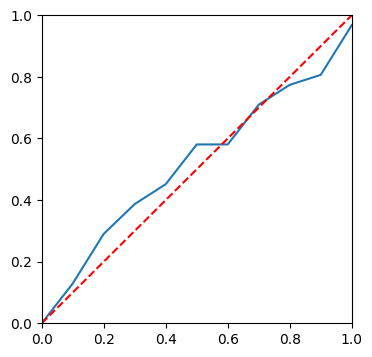

In [22]:
fig,ax = plt.subplots( figsize=(4,4) )
ax.plot( np.arange(0,1.1,0.1),counts )
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.add_line( Line2D( [0,1],[0,1],color="red",lw=1.5,ls="--" ) )


<h1>Model 2: Adding Lithology Data</h1>

In [141]:
realizations_per_sample = {  }
for i in range(df_train.shape[0]):
    withold_point = df_train.iloc[i,:]
    x_wh = withold_point[["logperm","acoustic_imp"]].values.reshape(-1,2)
    y_hw = withold_point["cumulative_3y"]
    new_df      = pd.concat( [df_train.iloc[0:i,:],df_train.iloc[i+1:,:]] )
    X           = new_df[["logperm","acoustic_imp"]].values
    y           = new_df["cumulative_3y"].values
    realizations_per_sample[ i ] = { "actual":y_hw,"reals":[  ] }
    for j in range(100):
        degree_rand = 3#np.random.randint( 4 )   
        model_type_rand =  0#np.random.randint( 0,4 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ),AdaBoostRegressor(  ),LinearRegression(  )]
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5 )
        model = model_types[model_type_rand]
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        if model_type_rand<=1:
            poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features=poly.fit_transform(X_train.reshape(-1,2))
            poly_test=poly.transform( x_wh.reshape(-1,2) )
            pipe.fit(poly_features, y_train)
            # ypred = pipe.predict( poly_test )
            # ytrainpreds = pipe.predict( poly_features )
            ywhp = pipe.predict( poly_test )[0]
        else:
            pipe.fit(X_train.reshape(-1,2), y_train)
            ywhp = pipe.predict( x_wh )[0]
        
        
        realizations_per_sample[ i ]["reals"].append( ywhp )

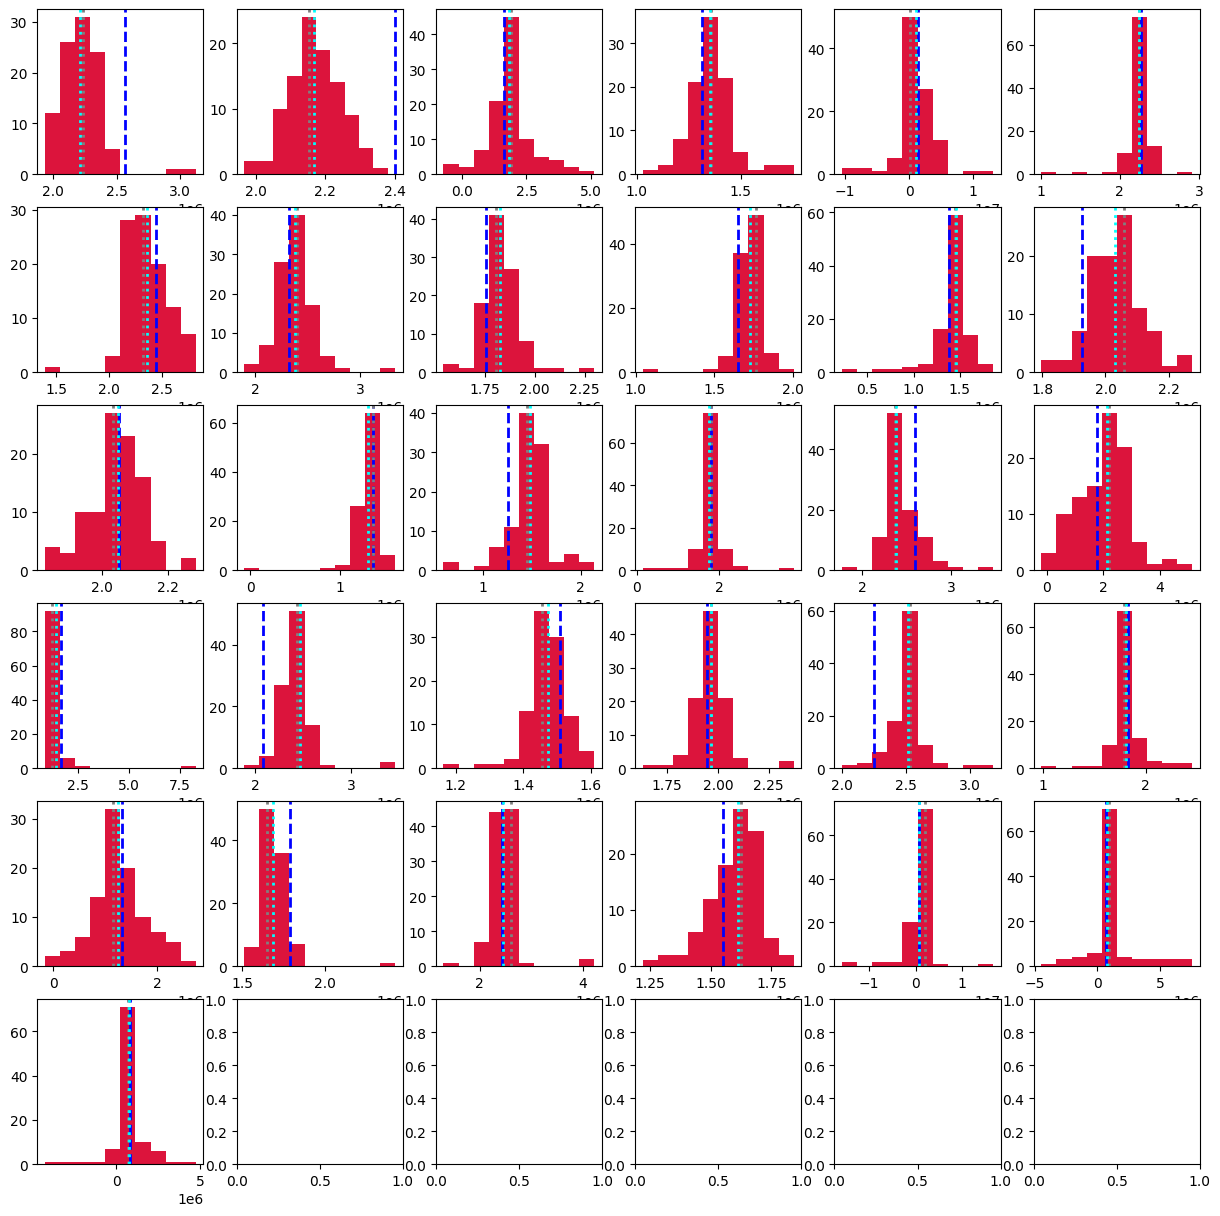

In [142]:
fig,axs = plt.subplots( 6,6,figsize=(15,15),facecolor="white" )
for k in range(df_train.shape[0]):
    row = k//6
    colm = k%6
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ k ]["reals"],color="crimson" )
    imax = np.argmax(counts)
    midpoint = 0.5 * (bin_edges[imax] + bin_edges[imax + 1])
    axs[row,colm].axvline( realizations_per_sample[ k ]["actual"],ls="--",lw=2.0,color="blue" )
    axs[row,colm].axvline( midpoint,ls="dotted",lw=2.0,color="gray" )
    axs[row,colm].axvline( np.median( realizations_per_sample[ k ]["reals"] ),ls="dotted",lw=2.0,color="cyan" )

In [143]:
counts = [ ]
for percent_value in np.arange(0,1.1,0.1):
    count = 0
    outside_range=1-percent_value
    for k in range(df_train.shape[0]):
        if (realizations_per_sample[ k ]["actual"]>=np.quantile( realizations_per_sample[ k ]["reals"],outside_range/2 )) and (realizations_per_sample[ k ]["actual"]<=np.quantile( realizations_per_sample[ k ]["reals"],1-outside_range/2 )):
            count += 1
    counts.append( count/df_train.shape[0] )
counts = np.array(counts)

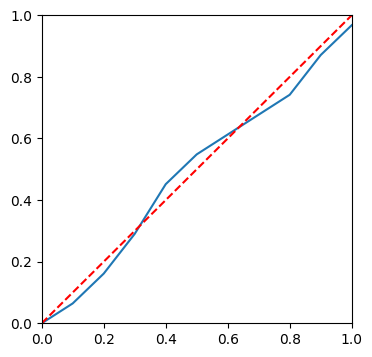

In [144]:
fig,ax = plt.subplots( figsize=(4,4) )
ax.plot( np.arange(0,1.1,0.1),counts )
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.add_line( Line2D( [0,1],[0,1],color="red",lw=1.5,ls="--" ) )

## Model 3: Two Models Separated by Facies Cluster (Spatially)

In [23]:
realizations_per_sample = {  }
for i in range(df_train.shape[0]):
    withold_point = df_train.iloc[i,:]
    x_wh = withold_point["logperm"].reshape(-1,1)
    x_loc = withold_point["x_east"]
    y_hw = withold_point["cumulative_3y"]
    new_df      = pd.concat( [df_train.iloc[0:i,:],df_train.iloc[i+1:,:]] )
    new_df_east = new_df[ new_df["x_east"]=="East" ]
    new_df_west = new_df[ new_df["x_east"]!="East" ]
    X_east           = new_df_east["logperm"].values
    y_east           = new_df_east["cumulative_3y"].values
    X_west           = new_df_west["logperm"].values
    y_west           = new_df_west["cumulative_3y"].values
    realizations_per_sample[ i ] = { "actual":y_hw,"reals":[  ] }
    for j in range(100):
        #Model East----------------------
        degree_rand = 2#np.random.randint( 1,3 )   
        model_type_rand =  np.random.randint( 0,1 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ),AdaBoostRegressor(  ),LinearRegression(  )]
        X_train_east, X_test_east, y_train_east, y_test_east = train_test_split( X_east, y_east, test_size=0.2 )
        model_east = model_types[model_type_rand]
        pipe_east = Pipeline( [('scaler', StandardScaler(  )), ('model', model_east)] )
        if model_type_rand<=1:
            poly_east=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features_east=poly_east.fit_transform(X_train_east.reshape(-1,1))
            poly_test_east=poly_east.transform( x_wh.reshape(-1,1) )
            pipe_east.fit(poly_features_east, y_train_east)
            # ywhp = pipe_east.predict( poly_test )[0]
            if x_loc=="East":
                ywhp = pipe_east.predict( poly_test_east )[0]
        else:
            pipe_east.fit(X_train_east.reshape(-1,1), y_train_east)
            # ywhp = pipe.predict( x_wh )[0]
            if x_loc=="East":
                ywhp = pipe_east.predict( x_wh )[0]


        #Model West---------------------
        degree_rand = 3#np.random.randint( 1,3 )   
        model_type_rand =  np.random.randint( 0,1 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ),AdaBoostRegressor(  ),LinearRegression(  )]
        X_train_west, X_test_west, y_train_west, y_test_west = train_test_split( X_west, y_west, test_size=0.75 )
        model_west = model_types[model_type_rand]
        pipe_west = Pipeline( [('scaler', StandardScaler(  )), ('model', model_west)] )
        if model_type_rand<=1:
            poly_west=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features_west=poly_west.fit_transform(X_train_west.reshape(-1,1))
            poly_test_west=poly_west.transform( x_wh.reshape(-1,1) )
            pipe_west.fit(poly_features_west, y_train_west)
            if x_loc=="West":
                ywhp = pipe_west.predict( poly_test_west )[0]
        else:
            pipe_west.fit(X_train_west.reshape(-1,1), y_train_west)
            if x_loc=="West":
                ywhp = pipe_west.predict( x_wh )[0]
            
        
        
        realizations_per_sample[ i ]["reals"].append( ywhp )

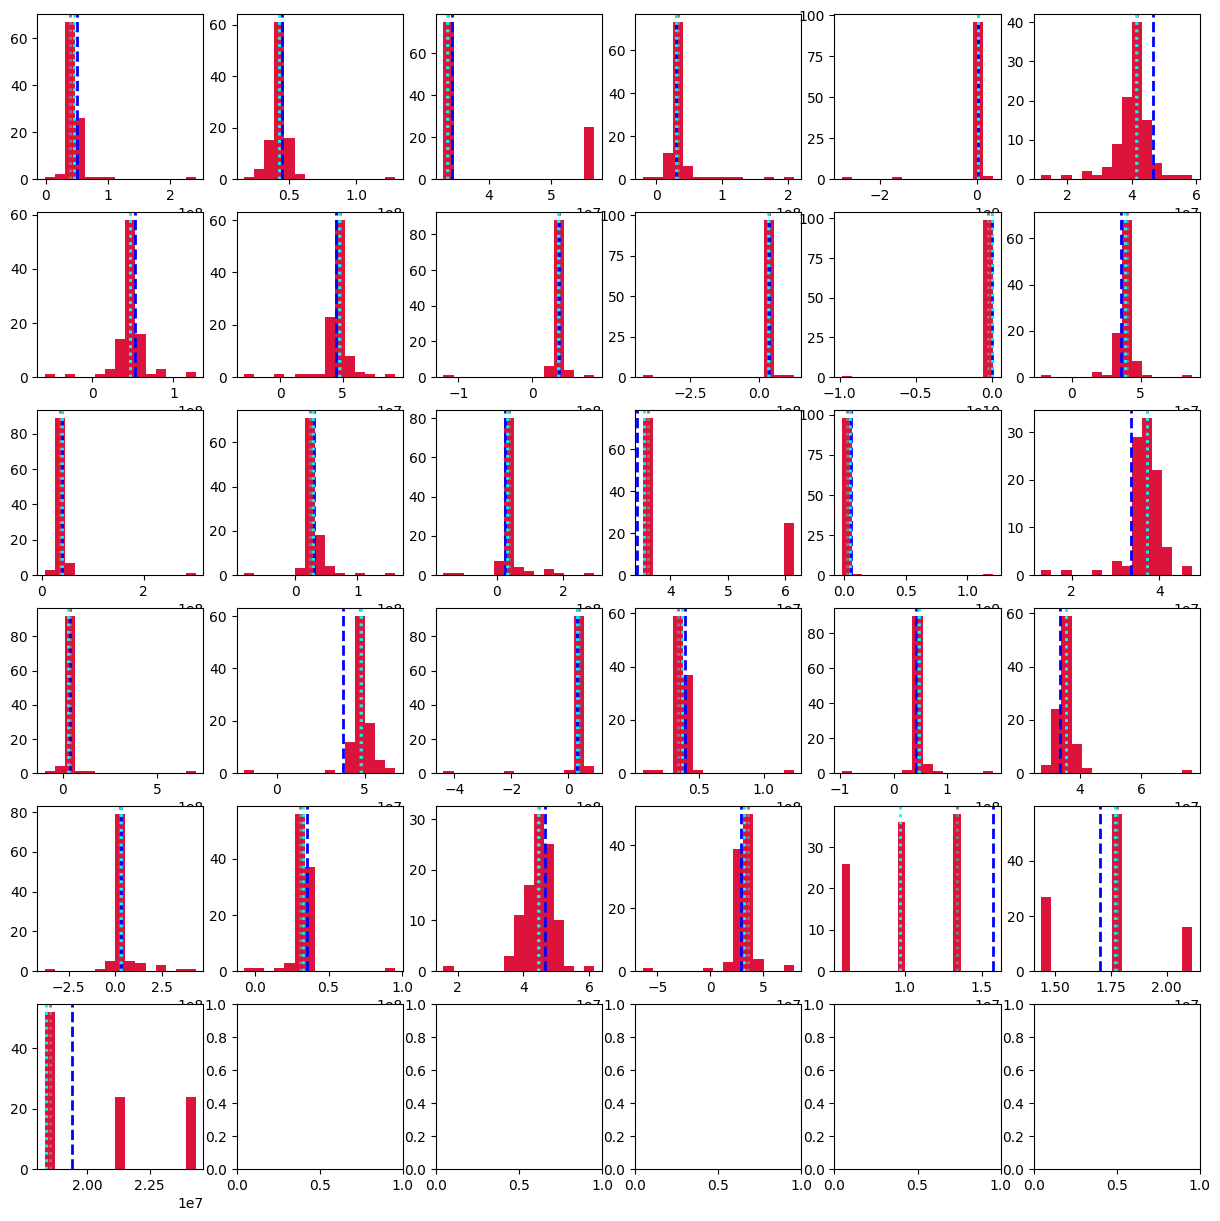

In [24]:
fig,axs = plt.subplots( 6,6,figsize=(15,15),facecolor="white" )
for k in range(df_train.shape[0]):
    row = k//6
    colm = k%6
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ k ]["reals"],color="crimson",bins=15 )
    imax = np.argmax(counts)
    midpoint = 0.5 * (bin_edges[imax] + bin_edges[imax + 1])
    axs[row,colm].axvline( realizations_per_sample[ k ]["actual"],ls="--",lw=2.0,color="blue" )
    axs[row,colm].axvline( midpoint,ls="dotted",lw=2.0,color="gray" )
    axs[row,colm].axvline( np.median( realizations_per_sample[ k ]["reals"] ),ls="dotted",lw=2.0,color="cyan" )

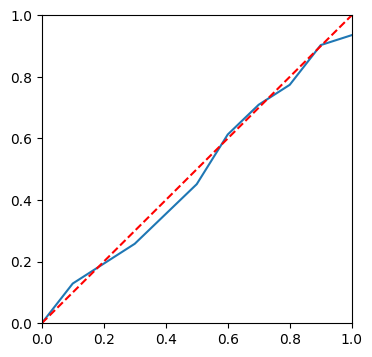

In [25]:
counts = [ ]
for percent_value in np.arange(0,1.1,0.1):
    count = 0
    outside_range=1-percent_value
    for k in range(df_train.shape[0]):
        if (realizations_per_sample[ k ]["actual"]>=np.quantile( realizations_per_sample[ k ]["reals"],outside_range/2 )) and (realizations_per_sample[ k ]["actual"]<=np.quantile( realizations_per_sample[ k ]["reals"],1-outside_range/2 )):
            count += 1
    counts.append( count/df_train.shape[0] )
counts = np.array(counts)
fig,ax = plt.subplots( figsize=(4,4) )
ax.plot( np.arange(0,1.1,0.1),counts )
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.add_line( Line2D( [0,1],[0,1],color="red",lw=1.5,ls="--" ) )

## FINAL PREDICTIONS - MODEL 1 (One Feature, One Model)

In [107]:
df_preproduction = pd.read_csv( "logs_preproduction.csv" )
df_preproduction["mean_perm"] = 0
for id in np.unique( df_preproduction["Well_ID"] ):
    print(np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] ))
    df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )

614.5193707165
1078.506667467619
936.0280205089524
1636.2010318947366
846.6214038333334
683.7977429293501
122.65067313336843
427.9245321080952
137.19931909204763
374.93761647785
286.17728327500004
433.69381494095234


/tmp/ipykernel_78487/2164575833.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '614.5193707165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )


In [108]:
df_preproduction = df_preproduction.groupby("Well_ID", as_index=False).first(  )

In [109]:
df_preproduction["logperm"] = np.log( df_preproduction["mean_perm"] )

In [110]:
realizations_per_sample_app1 = {  }
for i in range(df_preproduction.shape[0]):
    id = df_preproduction.iloc[i]["Well_ID"]
    Xinterest = df_preproduction.iloc[i]["logperm"]
    realizations_per_sample_app1[ id ] = { "best_pred":0.0,"realizations":[  ] }
    X           = df_train["logperm"].values
    y           = df_train["cumulative_3y"].values
    for j in range(100):
        degree_rand = 3 #Tuned via resampling (see code above)
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.80 )
        model = LinearRegression(  ) #Selected via resampling (see code above)
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
        poly_features=poly.fit_transform(X_train.reshape(-1,1))
        poly_test=poly.transform( Xinterest.reshape(-1,1) )
        pipe.fit(poly_features, y_train)
        ypred = pipe.predict( poly_test )[0]            
        realizations_per_sample_app1[ id ]["realizations"].append( ypred )
    realizations_per_sample_app1[ id ]["best_pred"] = np.median( realizations_per_sample_app1[ id ]["realizations"] )
    print( f"Best Prediction for Well {id} is: {realizations_per_sample_app1[ id ]['best_pred']} BBL." )
    


Best Prediction for Well 72.0 is: 1170301.8345724898 BBL.
Best Prediction for Well 73.0 is: 1799271.6537348493 BBL.
Best Prediction for Well 74.0 is: 1600721.2493265113 BBL.
Best Prediction for Well 75.0 is: 2516434.2457529968 BBL.
Best Prediction for Well 76.0 is: 1474220.086006079 BBL.
Best Prediction for Well 77.0 is: 1241257.9453424562 BBL.
Best Prediction for Well 78.0 is: 60924.945112184156 BBL.
Best Prediction for Well 79.0 is: 810519.5257126217 BBL.
Best Prediction for Well 80.0 is: 1257948.150326163 BBL.
Best Prediction for Well 81.0 is: 721690.4829101372 BBL.
Best Prediction for Well 82.0 is: 789396.973755206 BBL.
Best Prediction for Well 83.0 is: 836850.4926954901 BBL.


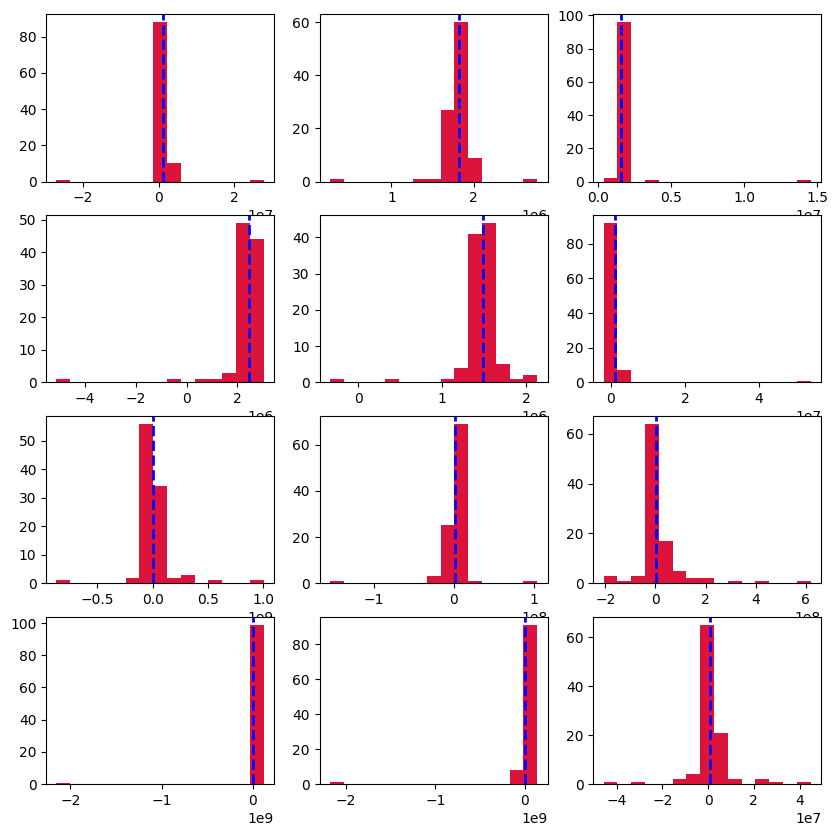

In [749]:
fig,axs = plt.subplots( 4,3,figsize=(10,10),facecolor="white" )
for k in range(df_preproduction.shape[0]):
    row = k//3
    colm = k%3
    id = df_preproduction.iloc[k]["Well_ID"]
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ id ]["realizations"],color="crimson",bins=15 )
    axs[row,colm].axvline( realizations_per_sample[ id ]["best_pred"],ls="--",lw=2.0,color="blue" )

In [714]:
df_solution = pd.read_csv( "solution.csv" )
for id in df_solution["Well_ID"].values:
    df_solution.loc[df_solution["Well_ID"]==id,"Prediction_BBL"] = realizations_per_sample[id]["best_pred"]
    df_solution.loc[df_solution["Well_ID"]==id, df_solution.columns[2:]] = realizations_per_sample[id]["realizations"]
df_solution

/tmp/ipykernel_56024/1579202467.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1197888.7071159668' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solution.loc[df_solution["Well_ID"]==id,"Prediction_BBL"] = realizations_per_sample[id]["best_pred"]
/tmp/ipykernel_56024/1579202467.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1194141.3741267417' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_solution.loc[df_solution["Well_ID"]==id, df_solution.columns[2:]] = realizations_per_sample[id]["realizations"]
/tmp/ipykernel_56024/1579202467.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1513589.0105465779' has dtype incompatible with int64, please 

Well_ID  Prediction_BBL            R1            R2            R3  \
0        72    1.197889e+06  1.194141e+06  1.513589e+06  2.019222e+06   
1        73    1.808666e+06  1.671809e+06  1.866773e+06  1.824681e+06   
2        74    1.603265e+06  1.260584e+06  1.572639e+06  1.441286e+06   
3        75    2.470782e+06  2.492736e+06  1.239805e+06  2.349943e+06   
4        76    1.469354e+06  1.462265e+06  3.006105e+06  1.474132e+06   
5        77    1.251737e+06  1.301437e+06  1.277569e+06  8.201080e+05   
6        78    1.670626e+06  7.415669e+06 -2.279760e+06 -1.342156e+07   
7        79    8.502449e+05  2.126096e+06 -7.689814e+05  7.616325e+05   
8        80    5.010997e+05  5.527067e+06 -3.265539e+06 -1.035206e+07   
9        81    7.203380e+05  4.572326e+06  7.214444e+05  1.348161e+06   
10       82    6.621987e+05  6.098668e+06  5.187757e+06  1.034469e+07   
11       83    9.178284e+05  3.707438e+05  9.071463e+05  7.580478e+05   

              R4            R5            R6            R7            R8  ...  \
0   1.418838e+06  9.233408e+05 -9.223167e+06  9.549834e+05  1.371304e+06  ...   
1   1.836126e+06  1.898564e+06  1.738466e+06  1.778516e+06  1.798383e+06  ...   
2   1.575400e+06  1.564416e+06  1.619491e+06  1.626407e+06  1.710462e+06  ...   
3   2.680247e+06  2.350346e+06  2.363406e+06  1.900533e+06  2.659052e+06  ...   
4   1.485832e+06  1.469925e+06  1.432111e+06  1.465940e+06  8.971991e+05  ...   
5   1.320226e+06  4.978535e+06  1.606657e+06  1.325512e+06  1.302532e+06  ...   
6   4.843275e+07  8.592143e+07  2.358843e+05  2.940362e+06  3.354412e+06  ...   
7   6.796718e+05  7.969751e+05  3.098775e+05  3.955561e+06  7.421923e+05  ...   
8   5.329142e+07 -6.763018e+07  1.171655e+08 -5.994844e+07 -4.898145e+07  ...   
9   3.606379e+06  3.712690e+06  7.225701e+05 -8.321733e+07  2.933120e+05  ...   
10  4.342701e+06  5.046484e+06  2.138572e+07  5.708887e+05  1.425633e+08  ...   
11  3.106618e+06 -7.465569e+06  7.789394e+05  8.178291e+05  1.597806e+06  ...   

             R91           R92           R93           R94           R95  \
0   1.153901e+06 -5.686985e+06  5.360337e+05  1.190327e+06  1.775101e+06   
1   1.945320e+06  1.882408e+06  1.742927e+06  1.875421e+06  1.855548e+06   
2   1.592678e+06  1.586083e+06  1.341560e+06  1.560265e+06  1.550555e+06   
3   2.394184e+06  2.508615e+06  2.601444e+06  2.640959e+06  2.320949e+06   
4   1.477732e+06  1.448200e+06  1.398815e+06  1.514769e+06  1.468574e+06   
5   1.244511e+06  1.201185e+06  1.052592e+07  1.294345e+06  1.276680e+06   
6   4.054161e+07 -2.650387e+08  7.450116e+07  2.058090e+06 -1.469153e+06   
7   3.338005e+06  8.506478e+05  4.206880e+06  2.690512e+06  7.154898e+05   
8   9.172597e+06  9.742878e+06  6.772235e+05  2.355112e+06 -1.174631e+08   
9   7.178772e+05 -7.162289e+06  7.427987e+05 -5.750646e+06 -1.662693e+06   
10  7.060655e+05 -9.049971e+06 -3.432950e+07  4.452628e+05  5.648096e+05   
11  6.377207e+06  1.061478e+06  1.066145e+06 -6.636311e+06  1.071936e+07   

             R96           R97           R98           R99          R100  
0   1.165655e+06  1.015011e+06  8.957322e+05  3.931180e+06  8.518485e+05  
1   1.774322e+06  1.787685e+06  1.820213e+06  1.850855e+06  1.879528e+06  
2   1.560093e+06  1.522821e+06  1.579321e+06  1.598149e+06  1.612981e+06  
3   2.565257e+06  2.503273e+06  1.892179e+06  2.726875e+06  2.664380e+06  
4   1.596257e+06  1.365528e+06  1.491278e+06  1.421814e+06  1.299546e+06  
5   4.878729e+05  4.899679e+06  1.314159e+06  6.516089e+06  1.031943e+06  
6  -1.660276e+07 -6.739622e+06 -1.790208e+06 -6.004011e+06 -1.408973e+06  
7   3.147770e+06  3.124523e+06 -4.800488e+06  9.228228e+05  3.068432e+06  
8  -4.965423e+06 -6.439751e+07 -3.423354e+07  1.266094e+07  4.897807e+07  
9  -3.470838e+06  7.181034e+05 -5.390727e+06  7.193963e+05 -2.210417e+06  
10 -4.086476e+07  1.003069e+05 -3.219778e+07  6.666264e+05  5.288212e+05  
11 -3.177011e+05  6.634023e+06  3.738182e+06  1.027224e+06  3.291449e+06  

[12 rows x 102 columns]

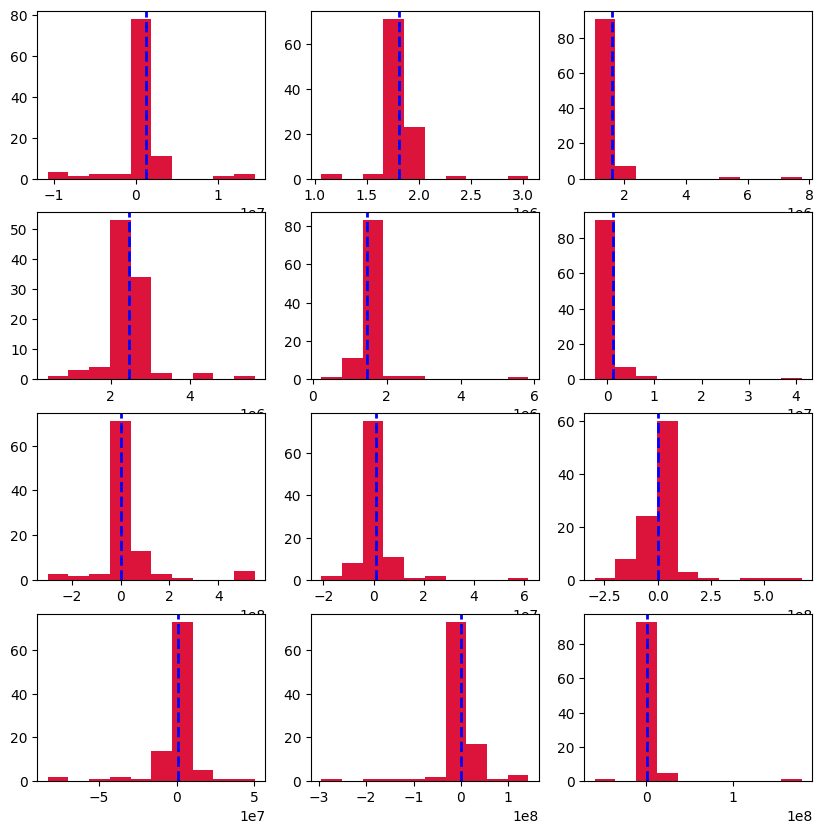

In [717]:
fig,axs = plt.subplots( 4,3,figsize=(10,10),facecolor="white" )
for k in range(df_preproduction.shape[0]):
    row = k//3
    colm = k%3
    id = df_preproduction.iloc[k]["Well_ID"]
    counts, bin_edges, patches = axs[row,colm].hist(  df_solution.loc[ df_solution["Well_ID"]==id,"R1":"R100" ].values.ravel(),color="crimson",bins=10 )
    axs[row,colm].axvline( df_solution.loc[ df_solution["Well_ID"]==id,"Prediction_BBL"].values,ls="--",lw=2.0,color="blue" )

In [750]:
df_solution.to_csv( "solution.csv",index=False )

## FINAL PREDICTIONS - MODEL 2 (Two Features, One Model)

In [148]:
df_preproduction = pd.read_csv( "logs_preproduction.csv" )
df_preproduction["mean_perm"] = 0
df_preproduction["acoustic_imp"] = 0
for id in np.unique( df_preproduction["Well_ID"] ):
    print(np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] ))
    df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )
    df_preproduction.loc[df_preproduction["Well_ID"]==id,"acoustic_imp"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["AI"] )

614.5193707165
1078.506667467619
936.0280205089524
1636.2010318947366
846.6214038333334
683.7977429293501
122.65067313336843
427.9245321080952
137.19931909204763
374.93761647785
286.17728327500004
433.69381494095234


/tmp/ipykernel_78487/2816661202.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '614.5193707165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )
/tmp/ipykernel_78487/2816661202.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5229836.131578947' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_preproduction.loc[df_preproduction["Well_ID"]==id,"acoustic_imp"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["AI"] )


In [149]:
df_preproduction = df_preproduction.groupby("Well_ID", as_index=False).first(  )

In [150]:
df_preproduction["logperm"] = np.log( df_preproduction["mean_perm"] )

In [152]:
realizations_per_sample_app2 = {  }
for i in range(df_preproduction.shape[0]):
    id = df_preproduction.iloc[i]["Well_ID"]
    Xinterest = df_preproduction.iloc[i][["logperm","acoustic_imp"]].values
    realizations_per_sample_app2[ id ] = { "best_pred":0.0,"realizations":[  ] }
    X           = df_train[["logperm","acoustic_imp"]].values
    y           = df_train["cumulative_3y"].values
    for j in range(100):
        degree_rand = 3 #Tuned via resampling (see code above)
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.50 )
        model = LinearRegression(  ) #Selected via resampling (see code above)
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
        poly_features=poly.fit_transform(X_train.reshape(-1,2))
        poly_test=poly.transform( Xinterest.reshape(-1,2) )
        pipe.fit(poly_features, y_train)
        ypred = pipe.predict( poly_test )[0]            
        realizations_per_sample_app2[ id ]["realizations"].append( ypred )
    realizations_per_sample_app2[ id ]["best_pred"] = np.median( realizations_per_sample_app2[ id ]["realizations"] )
    print( f"Best Prediction for Well {id} is: {realizations_per_sample_app2[ id ]['best_pred']} BBL." )
    

Best Prediction for Well 72.0 is: 1179194.7945890017 BBL.
Best Prediction for Well 73.0 is: 1806537.285654076 BBL.
Best Prediction for Well 74.0 is: 1654711.8425406744 BBL.
Best Prediction for Well 75.0 is: 2485495.5978033254 BBL.
Best Prediction for Well 76.0 is: 1484997.112536388 BBL.
Best Prediction for Well 77.0 is: 1184620.9623776984 BBL.
Best Prediction for Well 78.0 is: 3166697.1525002006 BBL.
Best Prediction for Well 79.0 is: 785083.2901935732 BBL.
Best Prediction for Well 80.0 is: 1013045.0480925776 BBL.
Best Prediction for Well 81.0 is: 487126.8202033482 BBL.
Best Prediction for Well 82.0 is: 637059.2986421556 BBL.
Best Prediction for Well 83.0 is: 809091.6996144333 BBL.


## FINAL PREDICTIONS - MODEL 3 (One Feature, Two Models)

In [26]:
df_preproduction = pd.read_csv( "logs_preproduction.csv" )
df_preproduction["mean_perm"] = 0
for id in np.unique( df_preproduction["Well_ID"] ):
    print(np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] ))
    df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )
df_preproduction = df_preproduction.groupby("Well_ID", as_index=False).first(  )
df_preproduction["logperm"] = np.log( df_preproduction["mean_perm"] )


614.5193707165
1078.506667467619
936.0280205089524
1636.2010318947366
846.6214038333334
683.7977429293501
122.65067313336843
427.9245321080952
137.19931909204763
374.93761647785
286.17728327500004
433.69381494095234


/tmp/ipykernel_92226/3224555041.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '614.5193707165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )


In [27]:
df_preproduction["x_east"] = np.where( df_preproduction["X"]>=80,"East","West" )
realizations_per_sample_app3 = {  }
for i in range(df_preproduction.shape[0]):
    id = df_preproduction.iloc[i]["Well_ID"]
    Xinterest = df_preproduction.iloc[i]["logperm"]
    x_loc = df_preproduction.iloc[i]["x_east"]
    realizations_per_sample_app3[ id ] = { "best_pred":0.0,"realizations":[  ] }
    new_df_east = df_train[ df_train["x_east"]=="East" ]
    new_df_west = df_train[ df_train["x_east"]!="East" ]
    X_east           = new_df_east["logperm"].values
    y_east           = new_df_east["cumulative_3y"].values
    X_west           = new_df_west["logperm"].values
    y_west           = new_df_west["cumulative_3y"].values
    for j in range(100):
        #Model East----------------------
        degree_rand = 2#np.random.randint( 1,3 )   
        model_type_rand =  np.random.randint( 0,1 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ),AdaBoostRegressor(  ),LinearRegression(  )]
        X_train_east, X_test_east, y_train_east, y_test_east = train_test_split( X_east, y_east, test_size=0.2 )
        model_east = model_types[model_type_rand]
        pipe_east = Pipeline( [('scaler', StandardScaler(  )), ('model', model_east)] )
        if model_type_rand<=1:
            poly_east=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features_east=poly_east.fit_transform(X_train_east.reshape(-1,1))
            poly_test_east=poly_east.transform( Xinterest.reshape(-1,1) )
            pipe_east.fit(poly_features_east, y_train_east)
            # ywhp = pipe_east.predict( poly_test )[0]
            if x_loc=="East":
                ypred = pipe_east.predict( poly_test_east )[0]
        else:
            pipe_east.fit(X_train_east.reshape(-1,1), y_train_east)
            # ypred = pipe.predict( Xinterest )[0]
            if x_loc=="East":
                ypred = pipe_east.predict( Xinterest )[0]


        #Model West---------------------
        degree_rand = 3#np.random.randint( 1,3 )   
        model_type_rand =  np.random.randint( 0,1 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ),AdaBoostRegressor(  ),LinearRegression(  )]
        X_train_west, X_test_west, y_train_west, y_test_west = train_test_split( X_west, y_west, test_size=0.75 )
        model_west = model_types[model_type_rand]
        pipe_west = Pipeline( [('scaler', StandardScaler(  )), ('model', model_west)] )
        if model_type_rand<=1:
            poly_west=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features_west=poly_west.fit_transform(X_train_west.reshape(-1,1))
            poly_test_west=poly_west.transform( Xinterest.reshape(-1,1) )
            pipe_west.fit(poly_features_west, y_train_west)
            if x_loc=="West":
                ypred = pipe_west.predict( poly_test_west )[0]
        else:
            pipe_west.fit(X_train_west.reshape(-1,1), y_train_west)
            if x_loc=="West":
                ypred = pipe_west.predict( Xinterest )[0]    
        
        
        realizations_per_sample_app3[ id ]["realizations"].append( ypred )
    realizations_per_sample_app3[ id ]["best_pred"] = np.median( realizations_per_sample_app3[ id ]["realizations"] )
    print( f"Best Prediction for Well {id} is: {realizations_per_sample_app3[ id ]['best_pred']} BBL." )

Best Prediction for Well 72 is: 25764305.157466277 BBL.
Best Prediction for Well 73 is: 34881547.2973766 BBL.
Best Prediction for Well 74 is: 32849378.585820373 BBL.
Best Prediction for Well 75 is: 50932630.683295995 BBL.
Best Prediction for Well 76 is: 30384888.182001222 BBL.
Best Prediction for Well 77 is: 26577512.424904346 BBL.
Best Prediction for Well 78 is: 13046973.869712938 BBL.
Best Prediction for Well 79 is: 19044594.709742263 BBL.
Best Prediction for Well 80 is: 12823938.891055275 BBL.
Best Prediction for Well 81 is: 17495403.27786483 BBL.
Best Prediction for Well 82 is: 15073806.586412646 BBL.
Best Prediction for Well 83 is: 19215662.799015753 BBL.


## Comparison Approaches

In [35]:
df_simon = pd.read_csv( "sol_simon.csv" )


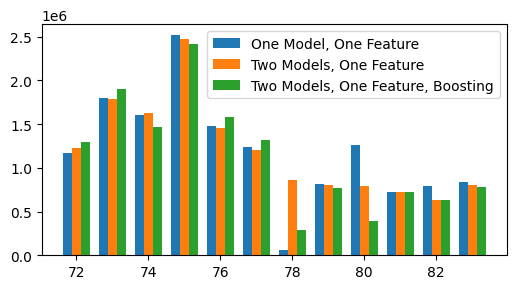

In [154]:
approach1 = [ realizations_per_sample_app1[x]['best_pred'] for x in realizations_per_sample_app1 ]
approach2 = [ realizations_per_sample_app2[x]['best_pred'] for x in realizations_per_sample_app2 ]
approach3 = [ realizations_per_sample_app3[x]['best_pred'] for x in realizations_per_sample_app3 ]
approach4 = df_simon["Prediction_BBL"]
fig,ax = plt.subplots( figsize=(6,3) )
x = df_preproduction["Well_ID"]
width=0.25
ax.bar(x - width, approach1, width, label='One Model, One Feature')
ax.bar(x,         approach3, width, label='Two Models, One Feature')
ax.bar(x + width, approach4, width, label='Two Models, One Feature, Boosting')
ax.legend(  )

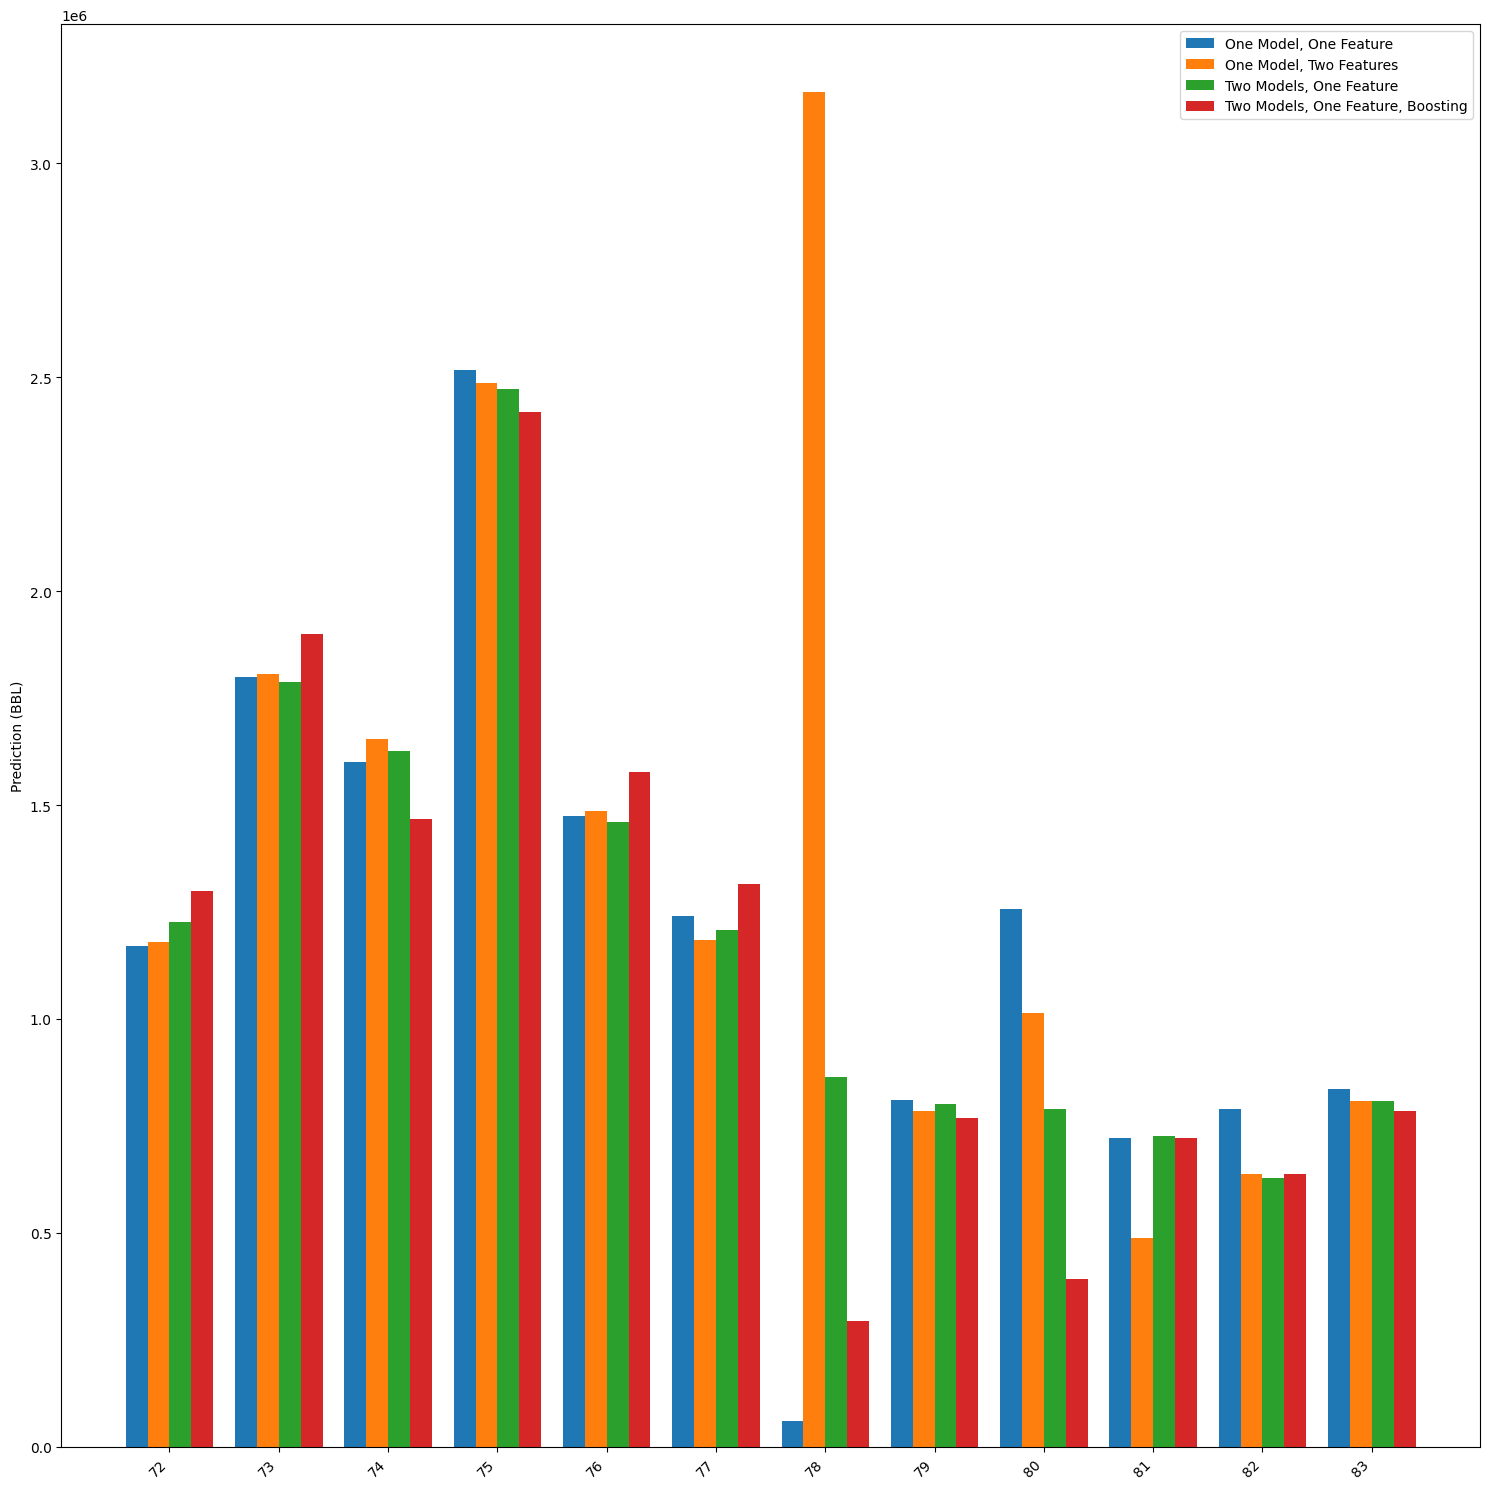

In [ ]:
approach1 = [realizations_per_sample_app1[x]['best_pred']
             for x in realizations_per_sample_app1]

approach2 = [realizations_per_sample_app2[x]['best_pred']
             for x in realizations_per_sample_app2]

approach3 = [realizations_per_sample_app3[x]['best_pred']
             for x in realizations_per_sample_app3]

approach4 = df_simon["Prediction_BBL"].values

fig, ax = plt.subplots(figsize=(15, 15))

x = np.arange(len(df_preproduction["Well_ID"]))
width = 0.2  # narrower for 4 bars

ax.bar(x - 1.5*width, approach1, width, label='One Model, One Feature')
ax.bar(x - 0.5*width, approach2, width, label='One Model, Two Features')
ax.bar(x + 0.5*width, approach3, width, label='Two Models, One Feature')
ax.bar(x + 1.5*width, approach4, width, label='Two Models, One Feature, Boosting')

ax.set_xticks(x)
ax.set_xticklabels(df_preproduction["Well_ID"], rotation=45, ha="right")

ax.set_ylabel("Prediction (BBL)")
ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_85654/1208994921.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_simon["Well_ID"], ha="right")
/tmp/ipykernel_85654/1208994921.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


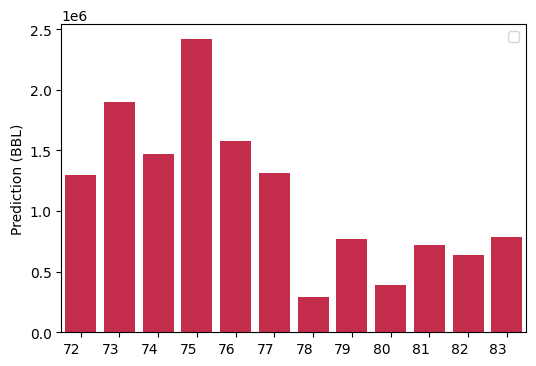

In [53]:
fig,ax=plt.subplots(figsize=(6,4))
approach4 = df_simon["Prediction_BBL"]
sb.barplot(df_simon["Prediction_BBL"],ax=ax,color="crimson")
x = df_simon["Well_ID"]
ax.set_xticklabels(df_simon["Well_ID"], ha="right")

ax.set_ylabel("Prediction (BBL)")
ax.legend()


/tmp/ipykernel_92226/823484756.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_preproduction["Well_ID"], ha="right")
/tmp/ipykernel_92226/823484756.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


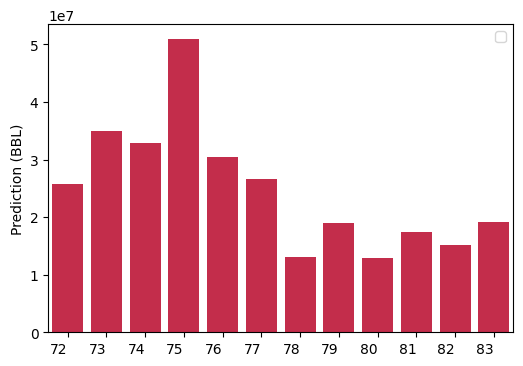

In [30]:
approach3 = np.array([ realizations_per_sample_app3[x]['best_pred'] for x in realizations_per_sample_app3 ])
fig,ax=plt.subplots(figsize=(6,4))
sb.barplot(approach3,ax=ax,color="crimson")
x = df_preproduction["Well_ID"]
ax.set_xticklabels(df_preproduction["Well_ID"], ha="right")

ax.set_ylabel("Prediction (BBL)")
ax.legend()


In [158]:
approach4

array([1299471.70405922, 1898747.86829193, 1467782.11690298,
       2419116.16173018, 1576083.36112214, 1314906.27695572,
        294328.11061583,  768686.41773699,  392747.98194852,
        721641.9383011 ,  637970.09790136,  783994.27661516])

In [159]:
approach3

[np.float64(1227523.4217486538),
 np.float64(1787969.4669920334),
 np.float64(1625275.8360071229),
 np.float64(2471573.318828868),
 np.float64(1461466.2955516707),
 np.float64(1208675.4986122982),
 np.float64(864431.2680573445),
 np.float64(800265.3169988837),
 np.float64(788769.5220139298),
 np.float64(727283.7483069851),
 np.float64(629375.1328316355),
 np.float64(808850.6333252783)]

### PC

In [240]:
df_pca = df_out[["gamma_var","gamma_mean","mean_por","mean_perm","Y","X","acoustic_imp","kophi_mean_of_sqrts","Well_ID","cumulative_3y"]]
print(f"rows: {df_pca.shape}")
df_pca = df_pca.dropna(  )
print(f"rows: {df_pca.shape}")

rows: (71, 10)
rows: (71, 10)


In [249]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
X = df_pca.iloc[:,:-1]
X_new = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
df_pca["pc1"] = X_new[:,0]
df_pca["pc2"] = X_new[:,1]

[9.20728953e-01 7.92710423e-02 3.74220673e-09 5.57382937e-10
 2.34196605e-10]


<Axes: xlabel='pc1', ylabel='pc2'>

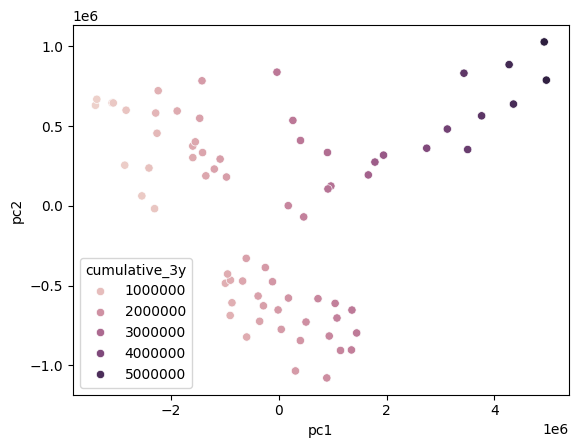

In [250]:
sb.scatterplot( data=df_pca,x="pc1",y="pc2",hue="cumulative_3y")#acoustic_imp" )

### Model Construction

In [259]:
# X = df_out[["gamma_var","mean_perm","mean_por"]].values
X = df_out[["X","Y"]].values
y = df_out["cumulative_3y"].values
kf = KFold(n_splits=5)#,shuffle=True)
r2scores = [  ]
for i, (train_index, test_index) in enumerate(kf.split(X)):
    pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', DecisionTreeRegressor(  ))] )
    X_train, X_test, y_train, y_test = X[train_index,:],X[test_index,:],y[train_index],y[test_index]
    pipe.fit(X_train, y_train)
    ypred = pipe.predict( X_test )
    r2scores.append( r2_score( y[test_index],ypred ) )


In [260]:
r2scores

[-2.3587450163011976,
 -0.5905180131060885,
 -19.28684989254235,
 -0.6675590240380394,
 -1.2465146420885826]